# MIE 1624H: Introduction to Data Science and Analytics- Fall 2019
## Assignment 1: Salary Classification Problem


In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn

## Import DataSet

### Reading Input Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import Binarizer
from sklearn.metrics import confusion_matrix
import seaborn as sns 

# Read in the Data

In [3]:
Salaries = pd.read_csv("Kaggle_Salary.csv", low_memory = False)

In [4]:
Salaries.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"


## 1.1 DATA CLEANING: Handling NaNs 

Columns deemed uninformative are:
1)I will be dropping columns Q11 and Q12 columns because I don't believe the amount on money spent on machine learning products by a select company will affect the salary of the data scientist; it might however make their job harder if they company doesn't invest in their field. In terms of Q12, I also don't think how the individual consumes data science-related media will affect their salary. 

2)I will also drop Q19 because the question is simply asking the individial for advice in terms of what language an aspiring data scientist should learn first; this, as a result does not affect the individual's salary. 

3)Furthermore, for Multiple choice questions such as Q9, they have 'TEXT' columns where the answer is a negative integer, these columns are uninformative, so they will dropped. Similarily for columns where the choice 'Other' was choosen also lack the ability to help our model to predict salary so they will also be dropped. i.e. The other choice was specific and thus is useless for this problem. 

4)I will also drop the time column.  

In [5]:
# dropping Q11
Salaries = Salaries.drop(['Q11'], axis =1)

#dropping Q12, since Q12 is split into multiple columns,I will filter the dataframe for columns that have the name 'Q12_Part_'
#and drop said columns
Salaries = Salaries[Salaries.columns.drop(list(Salaries.filter(regex='Q12_Part_')))]

#similarily for Q19
Salaries = Salaries.drop(['Q19'], axis =1)

# this code will filter for all columns that have the word 'TEXT' in the column, and then it will drop said columns
Salaries = Salaries[Salaries.columns.drop(list(Salaries.filter(regex='TEXT')))]

#in order to drop columns where the choice was other I would have to specify by columns names
Salaries = Salaries.drop(['Q9_Part_8', 'Q13_Part_12', 'Q16_Part_12', 'Q17_Part_12', 'Q18_Part_12',
                         'Q20_Part_12', 'Q21_Part_5', 'Q24_Part_12', 'Q25_Part_8', 'Q26_Part_7', 
                         'Q27_Part_6', 'Q28_Part_12', 'Q29_Part_12', 'Q30_Part_12', 'Q31_Part_12', 'Q32_Part_12',
                          'Q33_Part_12', 'Q34_Part_12'], axis =1)

# drop the time column
Salaries = Salaries.drop(['Time from Start to Finish (seconds)'], axis=1)

In [6]:
Salaries.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,...,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q10_Encoded,Q10_buckets
0,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"30,000-39,999"
1,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"0-9,999"


# 1.2 DATA CLEANING: Handling NaN values

Based on the code below, columns Q1 to Q8 don't have any NaN values but some do have categories that make up a very small percentage of the responses and thus some will be dropped, depending on their revelance. 

In [7]:
Salaries.isnull().sum(axis=0).iloc[0:8]

Q1    0
Q2    0
Q3    0
Q4    0
Q5    0
Q6    0
Q7    0
Q8    0
dtype: int64

### For Q1 - Age

For column age, I will not drop any of the age groups because it will be interesting to see what the average salary is for each age group. And also because I want my model to be able to predict salary for all ages.

In [8]:
Salaries.Q1.unique()

array(['22-24', '40-44', '50-54', '55-59', '30-34', '18-21', '35-39',
       '25-29', '45-49', '60-69', '70+'], dtype=object)

### For Q2 - Gender

There are four uniques categories for the gender column, as you can see from the code below categories 'Prefer not to say' and 'Prefer to self-describe' make up a very small percentage of the responses, so will drop rows with these responses

In [9]:
Salaries.Q2.value_counts(normalize=True)

Male                       0.838041
Female                     0.146195
Prefer not to say          0.013363
Prefer to self-describe    0.002401
Name: Q2, dtype: float64

In [10]:
# dropping rows where the gender is not specified
Salaries = Salaries[Salaries['Q2']!='Prefer not to say']
Salaries = Salaries[Salaries['Q2']!='Prefer to self-describe']

In [11]:
Salaries.Q2.unique()

array(['Male', 'Female'], dtype=object)

In [12]:
Salaries.shape

(12300, 187)

### Q3 - Country

Certain countries (e.g. singapore) had less than 40 respondents. These countries will be dropped because not enough data is present for training and testing on the model. 

In [13]:
Salaries.Q3.value_counts()[51:] # countries with less than 40 respondents

New Zealand       39
Philippines       39
Norway            39
Saudi Arabia      37
Czech Republic    37
Denmark           36
Algeria           36
Tunisia           33
Name: Q3, dtype: int64

In [14]:
Salaries = Salaries[Salaries['Q3']!='Norway']
Salaries =Salaries[Salaries['Q3']!='New Zealand']
Salaries =Salaries[Salaries['Q3']!='Philippines ']
Salaries =Salaries[Salaries['Q3']!='Saudi Arabia']
Salaries =Salaries[Salaries['Q3']!='Czech Republic']
Salaries =Salaries[Salaries['Q3']!='Denmark']
Salaries =Salaries[Salaries['Q3']!='Algeria']
Salaries =Salaries[Salaries['Q3']!='Tunisia ']

Salaries.shape

(12076, 187)

### Q4 - Education

From the code below we can see that Q4 has 6 categories, one of which is 'I prefer not to answer', this response will not help the model predict salary and thus will de dropped. Also since category 'No formal education past high school' make up a very small percentage of responses it will also dropped

In [15]:
Salaries.Q4.unique()

array(['Master’s degree', 'Professional degree', 'Bachelor’s degree',
       'Doctoral degree',
       'Some college/university study without earning a bachelor’s degree',
       'I prefer not to answer', 'No formal education past high school'],
      dtype=object)

In [16]:
Salaries.Q4.value_counts(normalize=True)

Master’s degree                                                      0.470768
Bachelor’s degree                                                    0.271696
Doctoral degree                                                      0.164127
Professional degree                                                  0.037264
Some college/university study without earning a bachelor’s degree    0.032958
I prefer not to answer                                               0.013415
No formal education past high school                                 0.009771
Name: Q4, dtype: float64

In [17]:
# drop the 'I prefer not to answer' response from column Q4
Salaries = Salaries[Salaries['Q4']!='I prefer not to answer']
# drop the 'I prefer not to answer' response from column Q4
Salaries = Salaries[Salaries['Q4']!='No formal education past high school']

In [18]:
Salaries.shape

(11796, 187)

### Q5 - Role/Position

All the categories in the Q5 column are valid, and none of them are too small in percentage distribution. So Q5 will not be changed

In [19]:
Salaries.Q5.value_counts(normalize=True)

Data Scientist             0.295693
Software Engineer          0.189556
Other                      0.115887
Data Analyst               0.113428
Research Scientist         0.101136
Business Analyst           0.054510
Product/Project Manager    0.053577
Data Engineer              0.043913
Statistician               0.021448
DBA/Database Engineer      0.010851
Name: Q5, dtype: float64

### Q6 - company workforce size

For Q6, there are 5 categories. I found the percentage of responses for each category and all of them are between 13-28%. Since there isn't any category with a small percentage, none of them will dropped and thus Q6 column will not be manipulated. 

In [20]:
# percentage of response for each category in question 6 
Salaries.Q6.value_counts(normalize=True)

0-49 employees          0.280688
> 10,000 employees      0.229315
1000-9,999 employees    0.193286
50-249 employees        0.164632
250-999 employees       0.132079
Name: Q6, dtype: float64

### Q8 - incorpating machine learning in business

Based on the code below, Q8 column has a category labelled as 'I do not know'. This category makes up 8% of the data in column Q8; that's a lot of data and thus it will not be dropped. 

In [21]:
Salaries.Q8.value_counts(normalize=True)

We are exploring ML methods (and may one day put a model into production)                    0.211343
We recently started using ML methods (i.e., models in production for less than 2 years)      0.208206
We have well established ML methods (i.e., models in production for more than 2 years)       0.191082
No (we do not use ML methods)                                                                0.184639
We use ML methods for generating insights (but do not put working models into production)    0.117667
I do not know                                                                                0.087063
Name: Q8, dtype: float64

###  Multiple choice Questions in General

There might be rows where the respondent didn't choose any of the options for the multiple choice question (a row with all NaNs) and thus I want to filter for such rows and drop them. 

In [22]:
filter_for = list(Salaries.filter(regex='_Part_'))
Salaries = Salaries.dropna(subset=filter_for, axis=0, how ='all')
Salaries.shape

(11515, 187)

For the multiply choice questions such as those since in Question 18, I am going to assume that all NaN values in such questions where left empty intentionally by the respondents as it did not apply to them. so I want to replace all NaN values in such as columns as 0, and all non-NaN values as 1. 

In [23]:
# filter for the multiple choice question (18) by filtering for the key word 'Part' 
MCquestions = list(Salaries.filter(regex='Part'))
for i in range (len(MCquestions)):
    Salaries[MCquestions[i]].fillna(0, inplace=True) # replace NaN values in filtered columns with zero

In [24]:
Salaries['Q18_Part_1'].unique() # this shows that the NaN values in 'Q18_Part_1' has been replaced with integer zero

array(['Python', 0], dtype=object)

The only remaining columns with NaN values are now just Q14, Q15, Q22, Q23. So let's see what we can do to clean them up.

In [25]:
nullvalues = Salaries.isnull().sum(axis=0)
nullvalues[nullvalues>0]

Q14     728
Q15     750
Q22    1522
Q23    1528
dtype: int64

### Q14 - What is the primary tool that you use at work or school to analyze data?

I think its safe to assume that individuals who didn't respond to this question didn't know what the primary tool used at work or school to analyse data. So I will replace the NaN with categpry called 'I don't Know'. 

In [26]:
Salaries.Q14.fillna("I don't know", inplace=True)

### Q15-How long have you been writing code to analyze data (at work or at school)?

It's hard to know why this question was left empty because the question gave them options from zero years to 20+ years. I think individuals who didn't answer this very relevant question (I believe it's very correlated to salary) will probably skew the accuracy of the model and so I will drop the NaN values in this column. There are only 750 rows with the NaN so we won't lose to much information by dropping them. 

Further I'm going to combine categories 'I have never written code' and '< 1 years' into a new category known as '0-1 years'. The reason I'm doing this is because I want the categories to be ordinal so that I can label encode them later (The column seems like a good candidate for ordinality and that's why I make a new category). 

In [27]:
Salaries = Salaries.dropna(subset=['Q15'], axis=0)

In [28]:
Salaries['Q15'] = Salaries['Q15'].str.replace('I have never written code','0-1 years')

In [29]:
Salaries['Q15'] = Salaries['Q15'].str.replace('< 1 years','0-1 years')

In [30]:
Salaries.Q15.value_counts()

3-5 years      2669
1-2 years      2598
0-1 years      2402
5-10 years     1654
10-20 years     945
20+ years       497
Name: Q15, dtype: int64

### Q22 - Have you ever used a TPU (tensor processing unit)?

Once again it's unclear why this question would be left empty, and thus I'm going to replace the NaN values with a new category called 'Unknown'.

In [31]:
Salaries.Q22.fillna("Unknown", inplace=True)

### Q23- For how many years have you used machine learning methods?

Similarily as Q22, I'm unsure why certain individual left this question empty, so I will replace it with category unknown

In [32]:
Salaries.Q23.fillna("Unknown", inplace=True)

In [33]:
Salaries.Q23.unique()

array(['1-2 years', 'Unknown', '2-3 years', '< 1 years', '10-15 years',
       '3-4 years', '4-5 years', '5-10 years', '20+ years'], dtype=object)

In [34]:
# Know let's check if we have any more NaNs in our dataset
nullvalues = Salaries.isnull().sum(axis=0)
print ("There are", len(nullvalues[nullvalues>0]), "columns with NaN values")

There are 0 columns with NaN values


### Reasons for selecting a subset of data

In order to move on to encoding, I'm going to choose a subset of data, particularly columns Q1-Q8, Q15, and Q18. I don't want to encode all the features because that would be time consuming and unnecessary, as I won't be using all the features. 

Age, gender, country, educational degree, role/position, size of column have an obvious impacts on salary and that's why they were choosen as features. Q8(applied ML in workplace) might affect salary because companies that apply ML means they are committed to field and thus are more likely to pay their workers more. Q15 was choosen for the obvious reason that coding experience definetly affects the salary (the more experience the higher the salary). Finally Q18 was selected because I'm assuming their is a correlation between the number of coded language known to salary (i.e. the more languages you know the higher your salary). 

In [35]:
Salaries_selected = Salaries[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6','Q7', 'Q8', 'Q15', 'Q18_Part_1', 'Q18_Part_2', 'Q18_Part_3',
                    'Q18_Part_4', 'Q18_Part_5', 'Q18_Part_6', 'Q18_Part_7', 'Q18_Part_8', 'Q18_Part_9', 'Q18_Part_10',
                    'Q18_Part_11', 'Q10_Encoded']]

In [36]:
Salaries_selected.shape

(10765, 21)

## 1.2.1 DATA Encoding: Label Encoding 

For features Q1, Q6, Q7, and Q15 which have incremental ranges I will use labelEncoder to encode the data. This is because these columns follow an ordinal relationship and thus it's better to use the label encoder function as preserves the order for the logisitic regression model. 

In [37]:
name = np.array(['Q1', 'Q6', 'Q7', 'Q15'])
name_change = np.array(['Q1_code', 'Q6_code', 'Q7_code', 'Q15_code'])

In [38]:
labelencoder = LabelEncoder()
for i in range(4):
    Salaries_selected[name_change[i]] = labelencoder.fit_transform(Salaries_selected[name[i]])

/Users/NADA/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
Salaries_selected[['Q1','Q1_code']].head(3)

,Q1,Q1_code
0,22-24,1
1,40-44,5
2,40-44,5


# 1.2.2 Data Encoding: OneHot Encoding

There remain unencoded columns follow an unordinal relationship (e.g. there isn't an ordered relationship between the column that contains countries). And thus the best method for this relationship is known as oneHot encoding. This method prevents our model from thinking their is an ordered relationship when there isn't.  
OneHot Encoding works by taking one column such as Q2-gender and converts the two categories in this column and produces two new columns. The first new column can represent female (female is labelled as 1, male as 0), and the second new column can represent male (male is labelled as 0, female as 1).  

In [40]:
col_name = ['Q2', 'Q3', 'Q4', 'Q5','Q8', 'Q18_Part_1', 'Q18_Part_2', 'Q18_Part_3',
                    'Q18_Part_4', 'Q18_Part_5', 'Q18_Part_6', 'Q18_Part_7', 'Q18_Part_8', 'Q18_Part_9', 'Q18_Part_10',
                    'Q18_Part_11']

In [41]:
salaries_coded = pd.get_dummies (data = Salaries_selected, columns = np.array(col_name)) # this is will be used in section 2
salaries_coded = salaries_coded.drop(['Q1', 'Q6', 'Q7', 'Q15'], axis=1)
#features = pd.get_dummies (data = Salaries_selected, columns = np.array(col_name))
#features = features.drop(['Q10_Encoded'], axis=1) # drop the salary bucket column as it is not part of the features 
#features.head(2)
salaries_coded.head(3)

,Q10_Encoded,Q1_code,Q6_code,Q7_code,Q15_code,Q2_Female,Q2_Male,Q3_Argentina,Q3_Australia,Q3_Austria,...,Q18_Part_7_0,Q18_Part_7_Javascript,Q18_Part_8_0,Q18_Part_8_TypeScript,Q18_Part_9_0,Q18_Part_9_Bash,Q18_Part_10_0,Q18_Part_10_MATLAB,Q18_Part_11_0,Q18_Part_11_None
0,3,1,1,0,1,0,1,0,0,0,...,0,1,1,0,1,0,0,1,1,0
1,0,5,4,4,0,0,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0
2,14,5,4,4,1,0,1,0,1,0,...,1,0,1,0,0,1,1,0,1,0


In [42]:
#Salaries.to_csv("Encoded_data.csv", index=False)

## 2.1 EXPLORATION DATA ANALYSIS - Visualization

### Visualizing Salary Distribution

I didn't want to illustrate salary distribution using the encoded columns, so made a new columns called Q10_new that includes the midpoint of the salary range that the respondents are in. For example if the respondent noted that they are in the 90,000-99,999 range then their salary will be noted as a 95,000 for the purpose of graphing

In [43]:
viz = Salaries[['Q2','Q3','Q4','Q5','Q10', 'Q15']] # features selected for visualization

In [44]:
viz['Q10_new'] = viz['Q10'].map({'$0-999': 500,
    '1,000-1,999': 1500,
    '2,000-2,999': 2500, 
    '3,000-3,999': 3500,
    '4,000-4,999': 4500,
    '5,000-7,499': 6250, 
    '7,500-9,999': 8750,
    '10,000-14,999': 11250,
    '15,000-19,999': 16250, 
    '20,000-24,999': 21250,
    '25,000-29,999': 26250,
    '30,000-39,999': 25000, 
    '40,000-49,999': 45000, 
    '50,000-59,999': 55000,
    '60,000-69,999': 65000,
    '70,000-79,999': 75000, 
    '80,000-89,999': 85000, 
    '90,000-99,999': 95000,
    '100,000-124,999':112500,
    '125,000-149,999':137500,
    '150,000-199,999':175000,
    '200,000-249,999':225000,
    '250,000-299,999':275000,
    '300,000-500,000':400000,
    '> $500,000':600000})

/Users/NADA/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Salary Distribution')

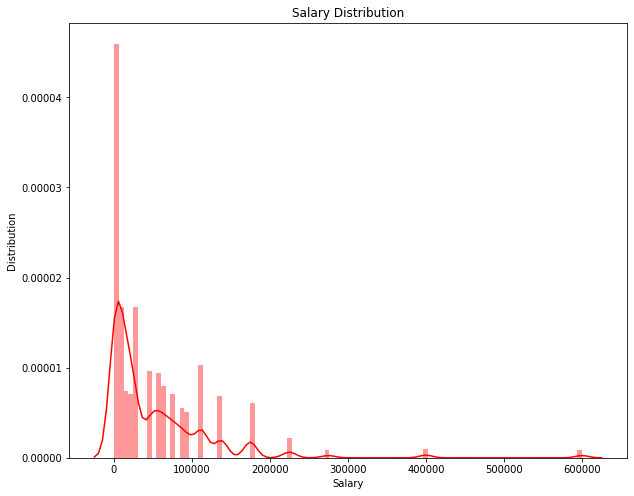

In [45]:
plt.figure(figsize=(10, 8))
sns.distplot(viz['Q10_new'], color='r', bins=100);
plt.xlabel('Salary')
plt.ylabel('Distribution')
plt.title('Salary Distribution')

In [46]:
salaries_coded.Q10_Encoded.value_counts(normalize =True)

0     0.307571
1     0.112587
2     0.082675
10    0.061403
3     0.060288
4     0.057966
5     0.056665
6     0.047469
7     0.042267
11    0.040780
12    0.036136
8     0.033442
9     0.030748
14    0.016628
13    0.013377
Name: Q10_Encoded, dtype: float64

The graph of the salary distribution leans heavily towards the lower salary ranges and has a long tail. This corresponds to the salary distribution shown in the code above, where the normalized numbers showed that the data lends heavily towards the smaller salaries. So the long tail is not suprising.

### Visualizing Salary based on education
In section 1.1, I found that most respondents either had a Master's Degree (approx. 48%) or a bachelor's degree. I though it would be interesting to see the difference in their salary distribution and thus I plotted them. 

In [47]:
# salary distribution based on education
Salaries_selected.Q4.value_counts(normalize=True)[0:2]

Master’s degree      0.484255
Bachelor’s degree    0.275337
Name: Q4, dtype: float64

In [48]:
bachelor_salary_values = np.array(viz[viz['Q4']=='Bachelor’s degree']['Q10_new'].values)
master_salary_values = np.array(viz[viz['Q4']=='Master’s degree']['Q10_new'].values)


n = 1000 # sample size
m = 10000 # number of times you complete the test
Nbach = len(bachelor_salary_values)
Nmast = len(master_salary_values)
bachelor_avg_salary = []
master_avg_salary = []
for i in range(m):
    bachelor_avg_salary.append(np.mean(bachelor_salary_values[np.random.randint(Nbach, size=n)]))
    master_avg_salary.append(np.mean(master_salary_values[np.random.randint(Nmast, size=n)]))

In [49]:
x_min = min(np.min(bachelor_avg_salary),np.min(master_avg_salary))
x_max = max(np.max(bachelor_avg_salary),np.max(master_avg_salary))

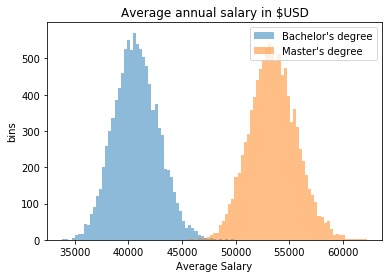

In [50]:
x = bachelor_avg_salary
y = master_avg_salary

bins = np.linspace(x_min, x_max, 100)

pyplot.hist(x, bins, alpha=0.5, label="Bachelor's degree")
pyplot.hist(y, bins, alpha=0.5, label="Master's degree")
#pyplot.legend(loc='upper right')
pyplot.legend(loc='best')
pyplot.title('Average annual salary in \$USD')
pyplot.xlabel('Average Salary')
pyplot.ylabel('bins')
pyplot.show()

The graph above shows that data scientist with a master's degree have a higher average salary than data scientist's with a bachelor's degree. This indicates that investing in a master's degree is benefinical, finicially, for one's data science career. 

### Salary distrubtion for each country for males and females

In [51]:
males = viz[viz['Q2']=='Male']
group_male = males.groupby('Q3')
country_male = group_male['Q10_new'].agg(np.mean)

female = viz[viz['Q2']=='Female']
group_female = female.groupby('Q3')
country_female = group_female['Q10_new'].agg(np.mean)
country_names = np.array(viz['Q3'].unique())
country_names.sort()

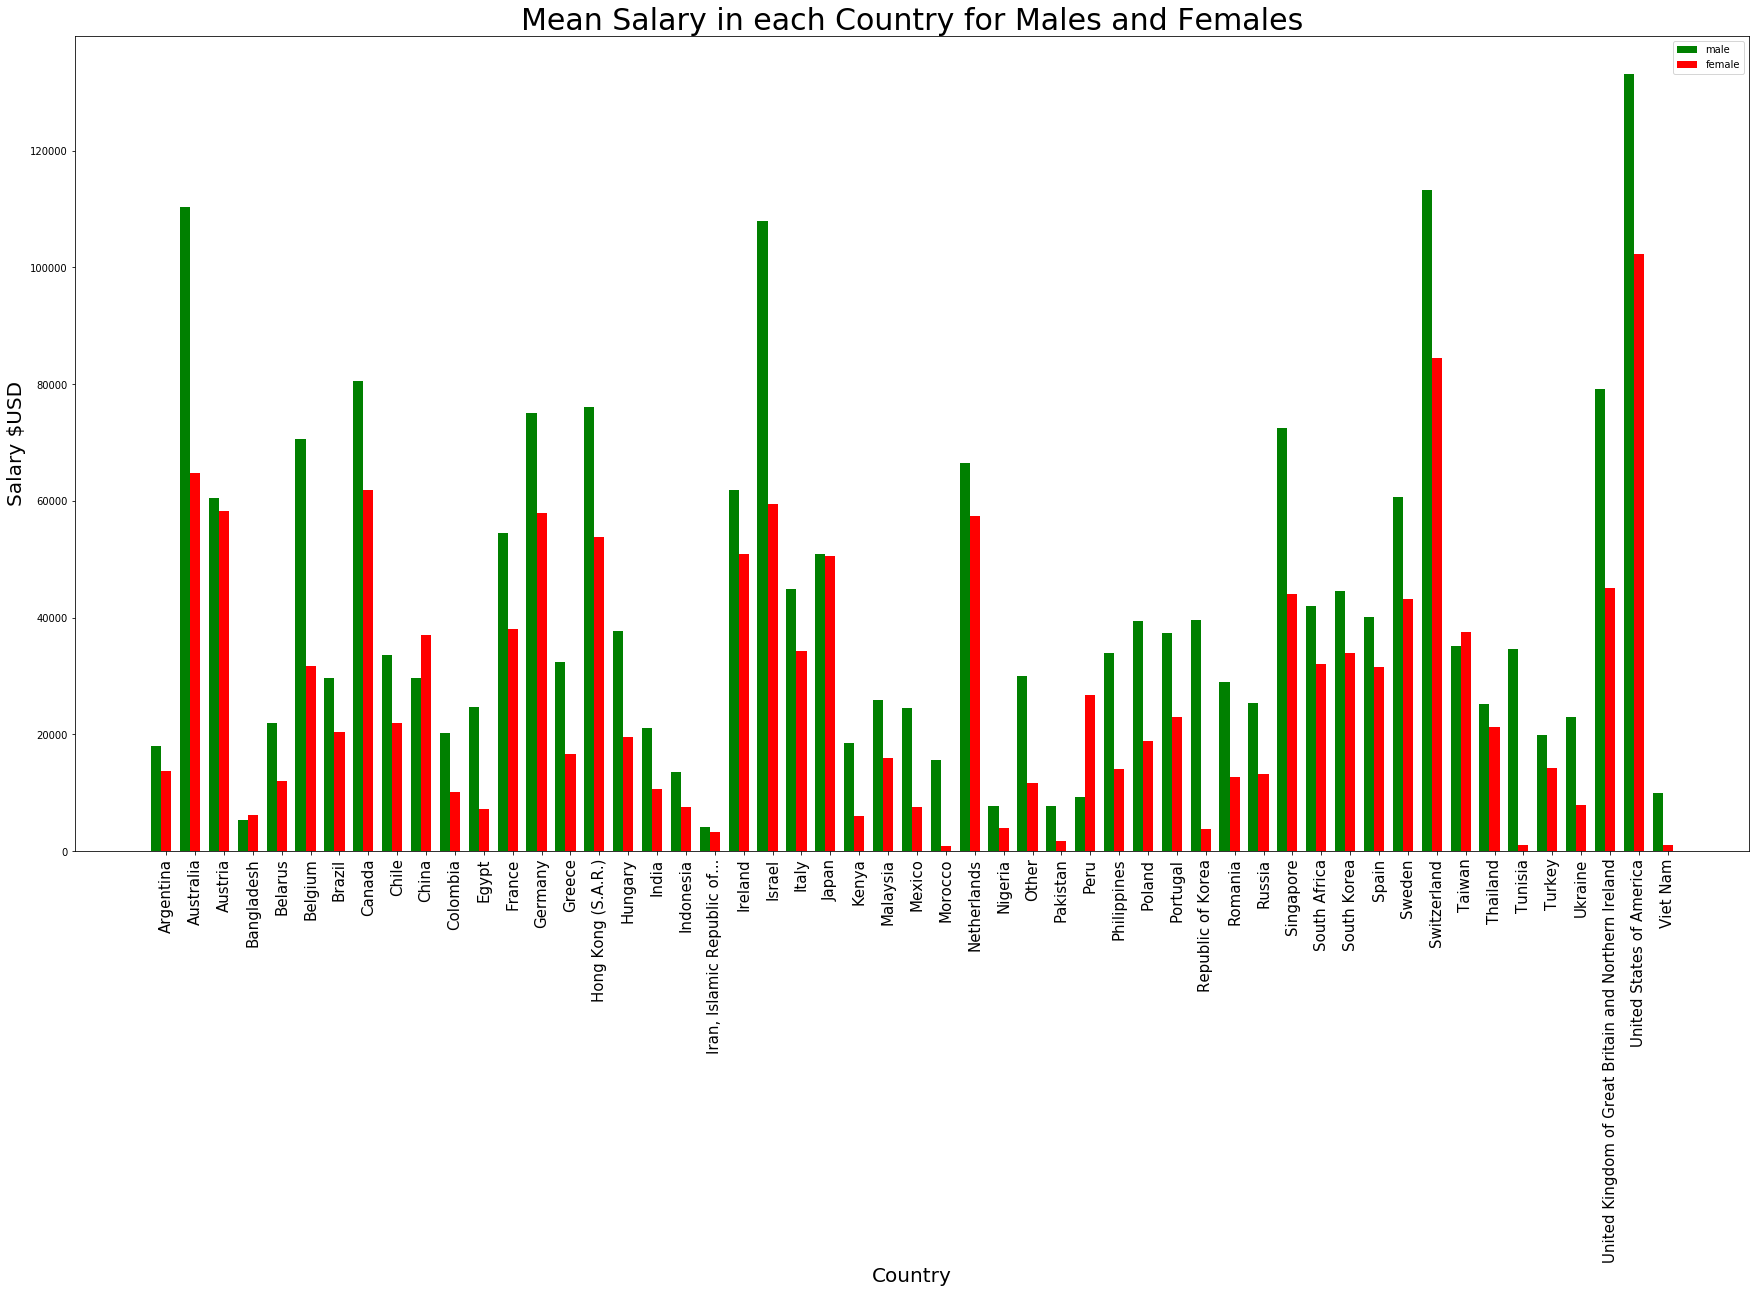

In [52]:
plt.figure(figsize=(30,15))
index = np.arange(len(country_male))
bar_width=0.35
plt.bar(index, country_male, bar_width, color='g', label='male')

plt.bar(index + bar_width, country_female, bar_width,color='r',label='female')

plt.xlabel('Country', size=20)
plt.ylabel('Salary \$USD', size=20)
plt.title('Mean Salary in each Country for Males and Females', size=30)
plt.xticks(index + bar_width, country_names, rotation=90, size=15)
plt.legend()
plt.show()

Unsurpsingly the graph above indicates that males get paid more in almost all countries, excluding Iran and Bangladesh were females get paid more. This is most likely due to the age pay gap that occurs in some countries. 

### Visualizing Coding Experince of Respondents

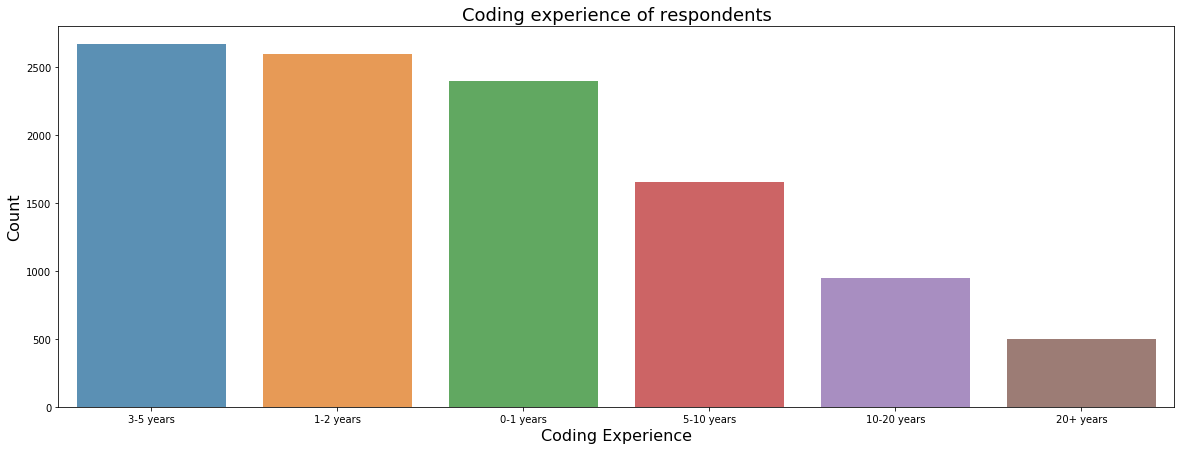

In [53]:
experience = viz['Q15'].value_counts() # count the number of occurrences of each experience range
plt.figure(figsize=(20,7))

sns.barplot(experience.index, experience.values, alpha=0.8)
plt.title('Coding experience of respondents',fontsize=18)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Coding Experience', fontsize=16)
plt.show()

As you can see from the graph above most of our dataset is leaning towards individuals that either 1-5 years of coding experience. 

## Visualize Salary based on Current Role 

Text(0.5, 0, 'Role')

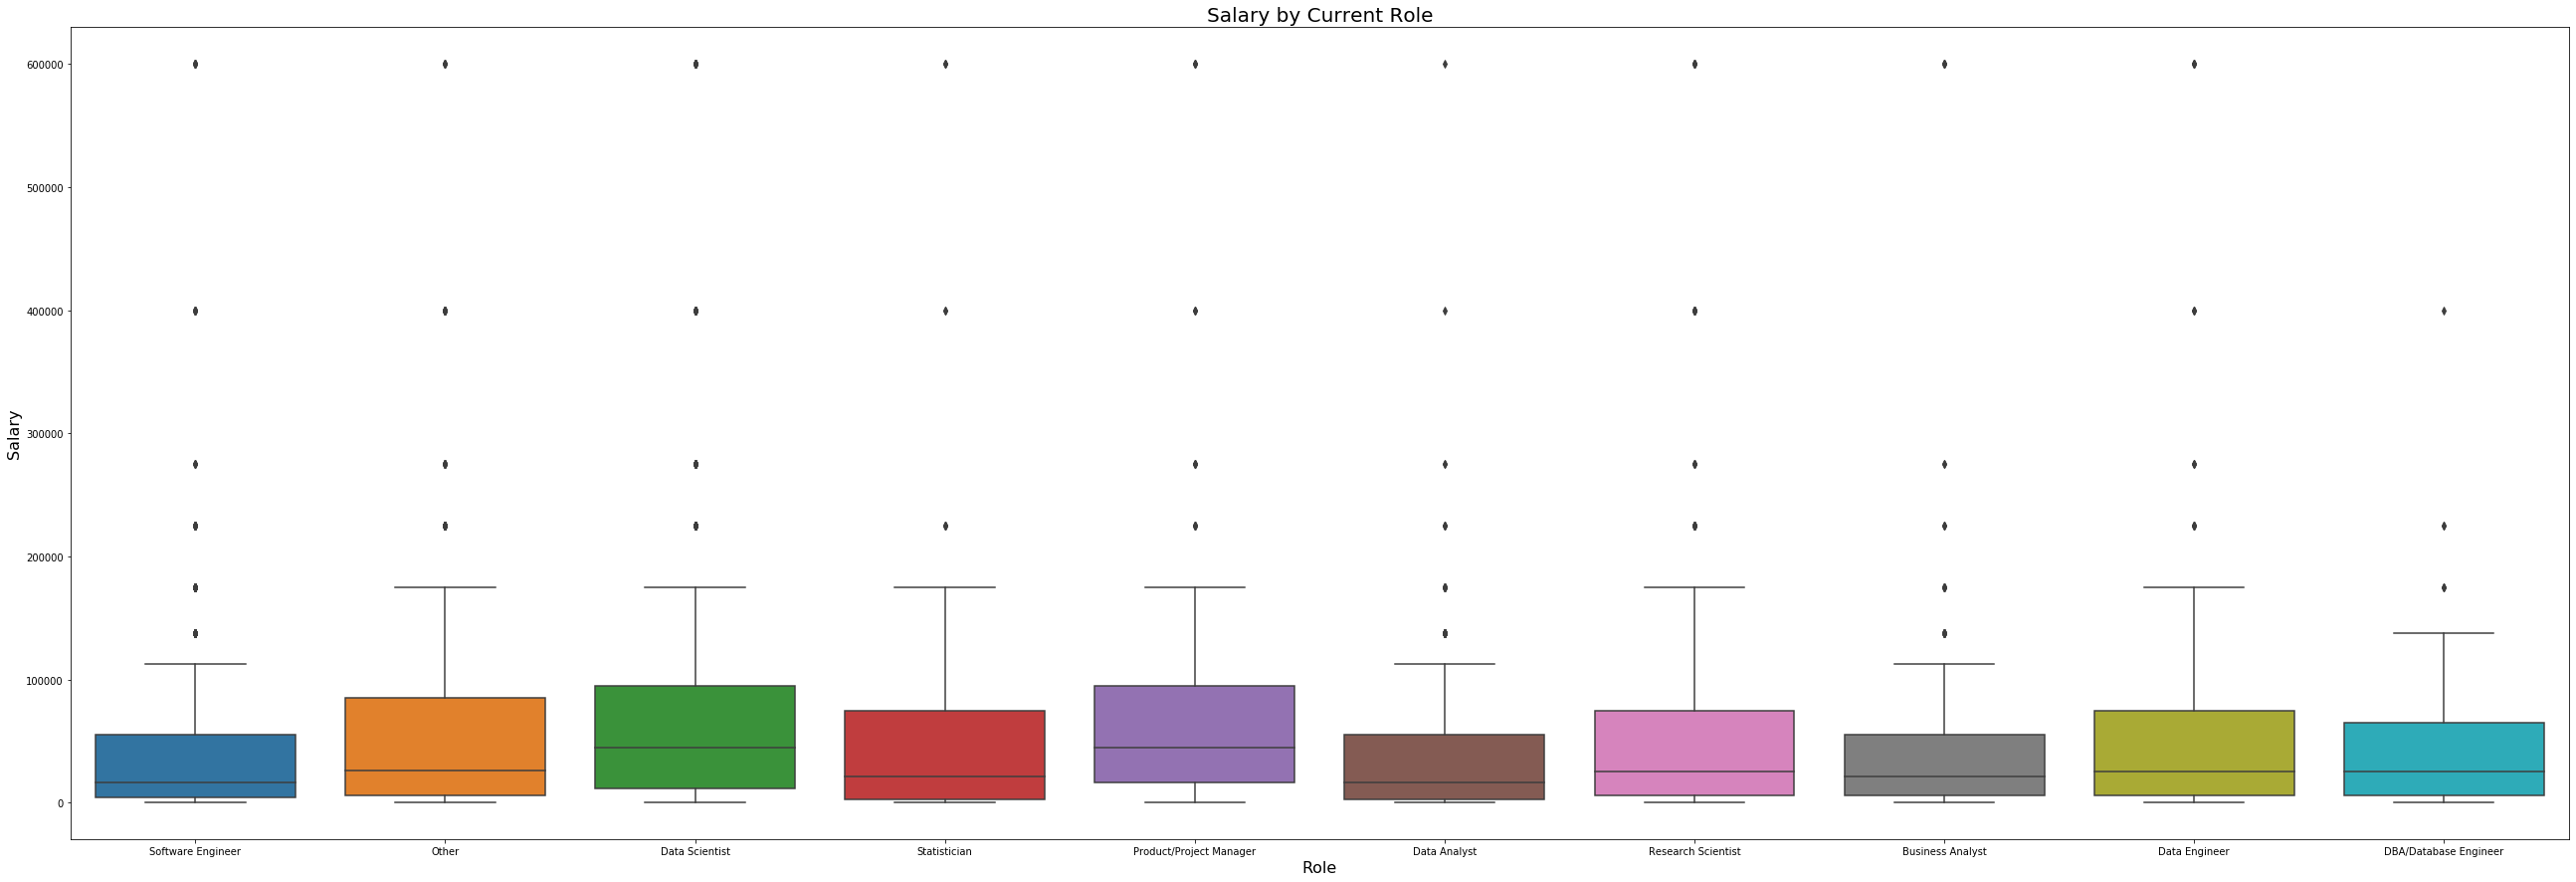

In [54]:
role_plot=(pd.DataFrame({"Salary": viz['Q10_new'],"Gender": viz['Q2'],"role": viz['Q5']}))
plt.figure(figsize=(45,15))
sns.boxplot(x="role", y="Salary",data=role_plot)
plt.title('Salary by Current Role',fontsize=20)
plt.ylabel('Salary', fontsize=16)
plt.xlabel('Role', fontsize=16)

## 2.2 EXPLORATION DATA ANALYSIS - Feature Importance

I didn't use a correlation matrix to depict feature importance because correlation plot was a mess and not informative visually, this is because we have 103 columns. So Instead I decided to use random forest. A random forest is an ensemble method that runs multiple decision trees over than given data. Usually one single decision tree doesn't produce the desired accuracy for classification or regression and thus we need to combine multiple decisions;  random forest ensembles these tree together to produce a final, more accurate, output.

In terms of feature importance, the decision trees are constructed in such a way that the most important features are above the less important features (i.e. it ranks the features). The order of the feature importance depends on the Information Gain(IG). Simply the IG evaluates how good our tree is, given that it is in a particular feature configuration, at predicting the target variable. The better the IG the better the feature configuration. Since we have a lot of features, it is more efficient to run random forest for feature importance.

pros of random forest:
- higher accuracy 
- can handle large number of features with high dimensioality

cons of random forest:
- tends to favour towards features that have more data
- slower than other methods (such as correlation matrix)

In [55]:
from sklearn.ensemble import RandomForestClassifier

features = salaries_coded.drop(['Q10_Encoded'], axis=1)
target = salaries_coded[['Q10_Encoded']]
features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

clf = RandomForestClassifier(random_state=0, n_jobs=-1)

model = clf.fit(features, target)
importances = model.feature_importances_ 

/Users/NADA/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/NADA/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


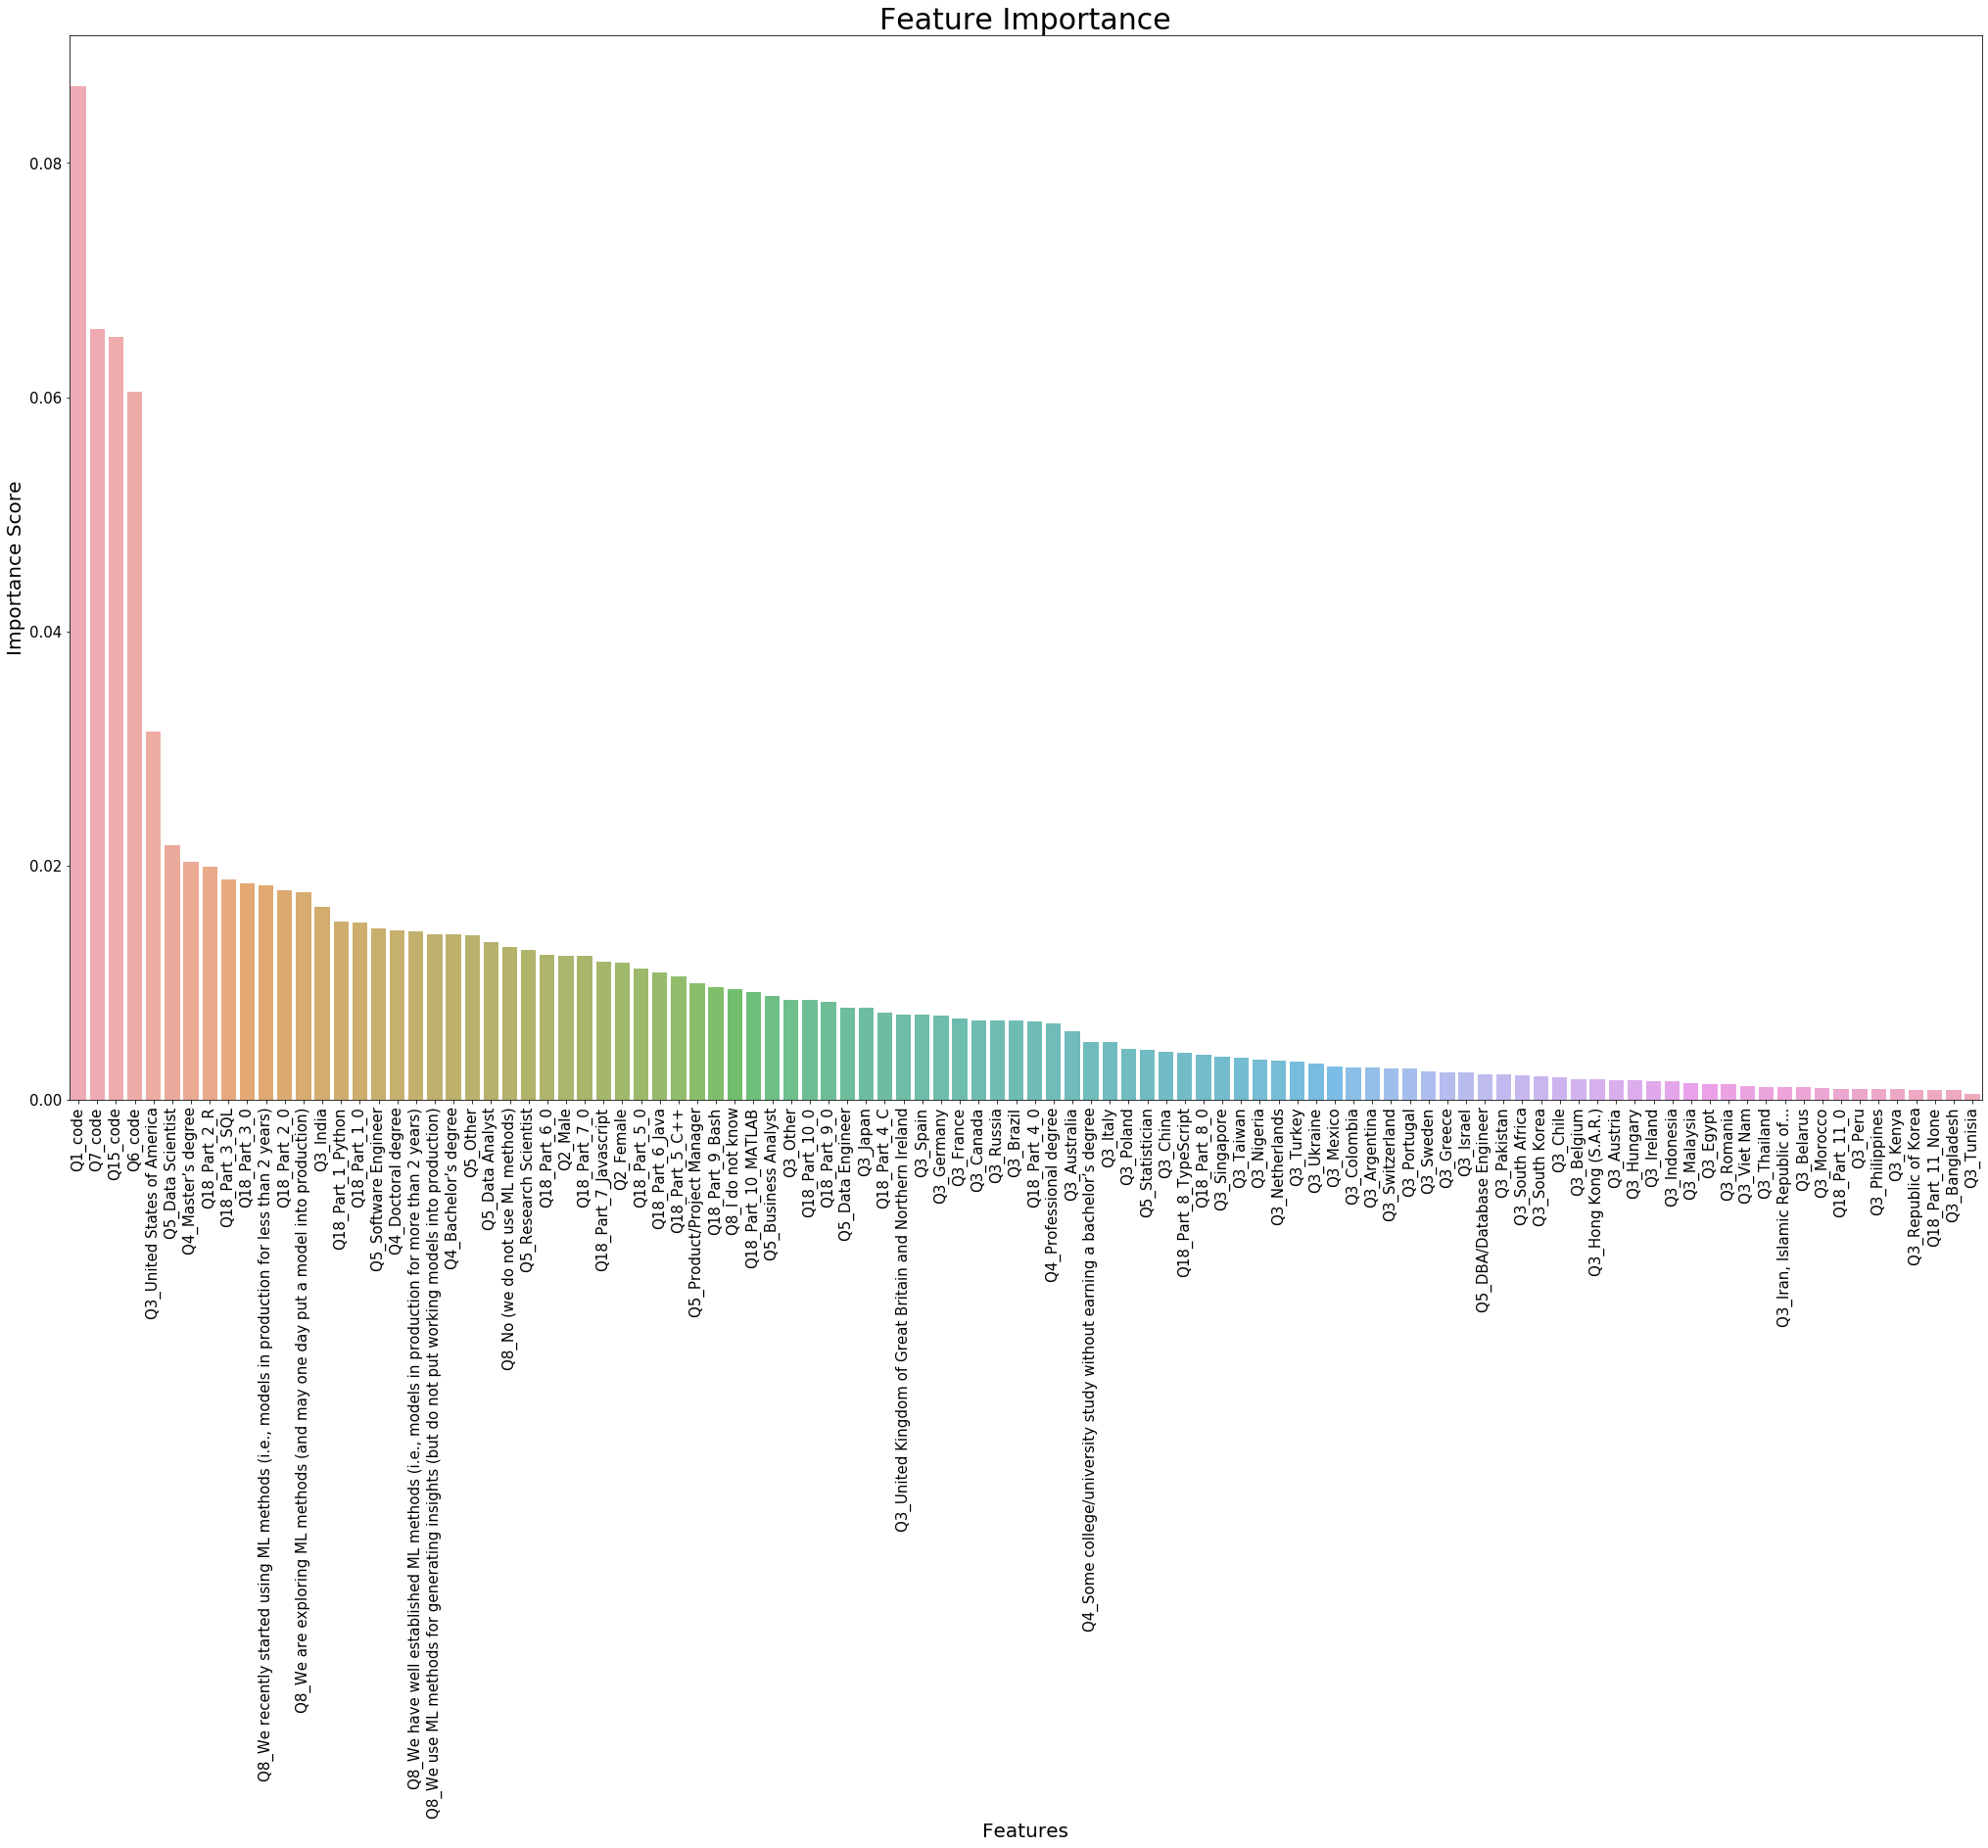

In [56]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features.columns[i] for i in indices]

plt.figure(figsize=(35,20))
sns.barplot(names, importances[indices], alpha=0.8)
plt.xticks(rotation=90, size =15)
plt.yticks(size=15)
plt.xlabel('Features', size = 20)
plt.ylabel('Importance Score', size = 20)
plt.title("Feature Importance", size=30)
plt.show()

Random Forest is showing me that Q1-Age, Q7-data science workload, and Q15-coding experience are the three most importance features of our dataset. 

## 3.0 FEATURE SELECTION - Lasso Regularization

The process of selecting relevant independent features from raw dataset is known as feature engineering. If feature engineering is done correctly it can increase the accuracy of the machine learning algorithm. It's what differentiates between a bad model and good model. Feature engineering also reduces the computation time and prevents overfitting of the model. When the data is high dimensional it can result in high complex model, which consequently leads to overfitting. Thus feature engineering can be used to reduces data dimensionality which results in a simpler model that has better predictive power. 

There are various techniques and algorithms that can used to complete feature engineering. Combining features, creating relevant features, and selecting features all lie under the scope that is feature engineering. For example, the random forest classifer I used in section 2.2 is a type of feature selection because it ranks the importance of features, and the least meaningful features can be removed it seems irrelevant to the scope of the problem. 

Although RandomForest can be used for feature selection, I will instead use Lasso Regularization. This is because RandomForest is biased towards categories with larger amounts of data, and since our dataset is unbalanced I believe it's better to use an algorithm which doesn't pose the same problem. 

Lasso regression is a regularization algorithm that prevents overfitting by minimizing irrelevant features from the data. Lasso is an example of L1 regularization, which adds a penalty equal to the absolute sum of the feature coefficients. The value of the coefficient represents the importance of the feature. L1 regularization is able to reduce the coefficients of unnecessary features to zero, thus eliminating them from the model completely. Ridge regression can't do this because it's penatly is a squared sum of the coefficients (this result in convex optimization where coefficients aren't minimized to zero). Therefore Lasso Regularization is the best method for feature selection in this case

Pros of Lasso:
- selects feature by shrinking coefficients to zero
- prevents overfitting

Cons of Lasso
- selects only one feature from a group of correlated features
- even though its great for feature selection, it can result in lower accuracy of the model compared to ridge. 

LassoCV is function that performs regularization using cross validation. CV works by splitting the training data into k equal sets, k-1 of the sets are used for training the model and the remaining set is used for testing. Each k set will undergo testing (i.e. if we have 10 sets the model will run 10 times using a different test set each time). The parameters from the set/fold that resulted in the lowest cost function are then applied on the (unseen) testing set to verify the results. Therefore applying CV to our lasso regression increases the accuracy of the model, which consequently results in better feature selection. 

In [57]:
lassoCV = LassoCV(normalize = False, cv =10)
lassoCV_res = lassoCV.fit(features, target)

lassoCV_alpha = lassoCV_res.alpha_

print('The best alpha is ',lassoCV_alpha)

/Users/NADA/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best alpha is  0.0032686093503291745


In [58]:
print("Lasso eliminated " + str(sum(np.array(lassoCV.coef_)==0)) + " features and selected " + str(sum(np.array(lassoCV.coef_)!=0)) + " featuers " ) 

Lasso eliminated 23 features and selected 79 featuers 


In [59]:
selected_features = features.columns[lassoCV.coef_!=0] # save the index of the features that weren't equal to zero

In [60]:
features = features[selected_features]

In [61]:
features.shape

(10765, 79)

In [62]:
target.shape

(10765, 1)

# 3.1 Feature Selection - Prinicple component Analysis  

Principle component analysis works by reducing the dimensionality of the data by evaluatign the variance of the features relative to one another. The features with the least amount of variance (compared to other features) can be eliminated (i.e. PCA tries to maximize variance of important features in the dataset to retain as much as information for a lower dimensional dataset). Most high dimensional data tend to include a lot of redundant features and thus PCA functions to remove such features. 
In general the Pros and cons oh PCA are-
Pros:
- Improves algorithm efficiency by eliminating irrelevant features
- reduces overfitting
- improves visualization

cons:
- harder to interpret the features because they are being converted to principal components
- standardization is required 

For our problem scope, I noticed that PCA didn't affect the accuracy of logisitic model. I graphed the explained variance graph to show why.

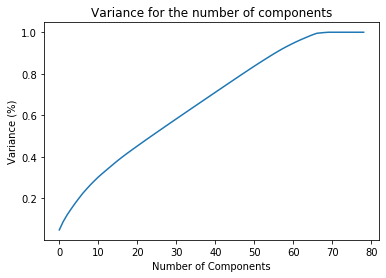

In [63]:
from sklearn.decomposition import PCA

scale = StandardScaler()
features_scale = scale.fit_transform(features)

pca= PCA().fit(features_scale,target)

#plotting the variance for the different components
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")
plt.title("Variance for the number of components")
plt.show()

In [64]:
var = np.cumsum(pca.explained_variance_ratio_)

In [65]:
print ("The number of features retained from PCA are", len(var[var<=0.95]), "features")

The number of features retained from PCA are 61 features


In [66]:
#pca = PCA(n_components=62)
#features_PCA = pca.fit_transform(features_scale)

As you can see from the graph above, using PCA reduces the number of features from 79 to 61. This reduction didn't have an affect on the accuracy of the model. When I applied PCA to the ordinal logisitic model the accuracy actually gets worse (goes from 35% to 34%), this might be because the model doesn't have enough features. Since I already have a relative low number of features(71), using PCA might be eliminating useful features and that will explain the decrease in accuracy of the model. Also since PCA doesn't consider our target varaiable it might be making it harder on the model to find relationship between the independent feature and the target values. If I had larger number ofe features, PCA might work better. 

## 4.1 MODEL IMPLEMENTATION: Ordinal Logisitic Regression

The problem we are dealing with in this project has an ordinal target varaible and thus we can't apply simple logistic regression only. The way we deal with ordinal labels is through binary classification. Since our target is multiclass we perform binary classification by converting the first salary bucket to a 0 and the rest of the salary buckets to 1, we then fit our linear regression model on this data and find the probability. We then combine the first and second salary bucket into one class that's labelled a 0, while the rest of the buckets are labelled 1; the modelled is fitted and the probability is predicted. The probability of the combined class (which includes bucket 0 and bucket 1) is then subtracted by the probability from the first case (which includes only bucket 0) to obtain the probability of bucket 1. This approach is applied for all the salary buckets, and is known as multiclass binary classification. 

Once the probabilities for all buckets are found, we pick the highest probability in each row as the predicted salary. (the final probability table will have 15 columns representing 15 salary buckets). 

In order to better determine the model's ability to predict salary, it would be better to look at the accuracy of each fold in the cross validation. This is what the code below accomplishes with 10-fold cross validation. 

In [67]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")


In [68]:
# the binarizer function converts the target to binary values. You can specify the threshold of the binarizer. 
#(i.e. values higher than the threshold will be mapped as a 1). Needed 14 binarizer because there are 14 buckets. 
# the threshold of the last bucket is 13. 
binarize_y = []
for i in range (14):
    binarize_y.append(Binarizer(i))

### Building the Ordinal model Function

In [69]:
def ordinal_fit_predict(X_train,X_test, y_train, y_test, C, solver):
    
    #fit the ordinal model
    ordinalClassifiers = [] # this will result in 14 ordinal models
    for i in range (14):
        y_new = binarize_y[i].fit_transform(y_train) 
        ordinalClass = LogisticRegression(C=C, solver=str(solver))
        ordinalClass.fit(X_train,y_new) 
        ordinalClassifiers.append(ordinalClass)
        
    # use each ordinal model to obtain the probabilities for each binarized salary buckets
    probabilities = []
    for i in range(14):
        prob = ordinalClassifiers[i].predict_proba(X_test)
        probabilities.append(prob)
    
    # subtract the probabilities to get the probability in each class
    probab = []
    for j in range(14):
        if j ==0:
            probab.append(probabilities[j][:,0]) # classes 0
        elif j>0 and j<13:
            probab.append(probabilities[j][:,0] - probabilities[j-1][:,0]) # classes 1-12 
        else:
            probab.append(probabilities[12][:,0]- probabilities[13][:,0]) # class 13
            probab.append(probabilities[13][:,1]) # class 14
    
    #organize the probabilities in a dataframe
    final_probabilities = abs(np.array(probab).T)
    df = pd.DataFrame(data=final_probabilities)
    df['predicted_class'] = df.idxmax(axis=1)
    return df

#### Applying the Ordinal model using CV

In [70]:
kfold = KFold(n_splits=10)
kfold.get_n_splits(features)

target = pd.DataFrame(data=target) # binarizer expects a 2d array so I converted the target to dataframe, features was already a dataframe
features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

accuracy = []
np_idx = 0

for train_idx, test_idx in kfold.split(features):
    X_train, X_test = features.values[train_idx], features.values[test_idx]
    y_train, y_test = target.values[train_idx], target.values[test_idx]
    
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    
    df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=1, solver='lbfgs') #solver lbfgs is the default solver
    
    # isolate the predicted class to determine accuracy
    pred = df['predicted_class']
    accuracy_score(y_test, pred) *100
    
    ACC = accuracy_score(y_test, pred) *100
    accuracy.append(ACC)
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3))) 

Fold 1: Accuracy: 32.498%
Fold 2: Accuracy: 33.055%
Fold 3: Accuracy: 38.162%
Fold 4: Accuracy: 32.312%
Fold 5: Accuracy: 33.333%
Fold 6: Accuracy: 33.086%
Fold 7: Accuracy: 39.87%
Fold 8: Accuracy: 35.781%
Fold 9: Accuracy: 38.476%
Fold 10: Accuracy: 40.706%
Average Score: 35.728%(3.121%)


In [71]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,predicted_class
0,0.647158,0.200774,0.087813,0.024107,0.013560,0.005617,0.000823,0.005608,0.002774,0.002946,0.003291,0.002684,0.001332,0.000125,0.001640,0
1,0.773091,0.129670,0.042712,0.016327,0.011736,0.005288,0.003902,0.006616,0.001804,0.000064,0.000479,0.000829,0.000483,0.003333,0.006290,0
2,0.631136,0.335365,0.032711,0.000175,0.000114,0.000084,0.000076,0.000010,0.000016,0.000025,0.000070,0.000044,0.000055,0.000013,0.000106,0
3,0.741005,0.134703,0.053077,0.023813,0.022802,0.011625,0.004502,0.003395,0.001108,0.001941,0.000877,0.000555,0.000315,0.000068,0.000351,0
4,0.763748,0.123948,0.044999,0.019940,0.013686,0.008836,0.006813,0.009439,0.002364,0.001047,0.001519,0.000872,0.001547,0.001479,0.002856,0


We know want to look at the accuracy if we change some of the hyperparameters of the model. This includes hyperparamters: C(regularization parameter) and the solver. Since cross validation takes a bit of time to run, I will evaluate the model using average accuracy rather than fold accuracy. 

### Visualizing confusion matrix for untuned ordinal regression

In [72]:
predicted_ordinal = df['predicted_class'] 

(14.95, -0.01)

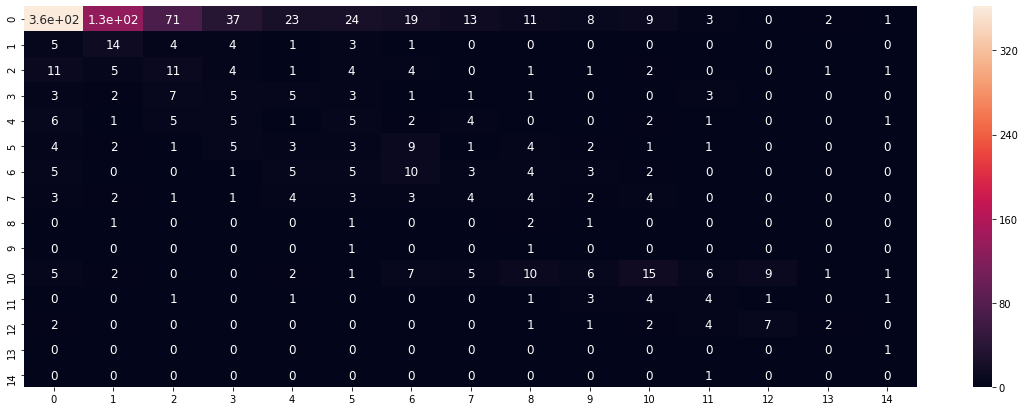

In [73]:
cm = confusion_matrix(predicted_ordinal,y_test)

df_cm = pd.DataFrame(cm, range(15), range(15))
plt.figure(figsize = (20,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.ylim(len(cm)-0.05, -0.01)

The confusion matrix shows that salary bucket 0, this makes sense as the salary distribution illustrated in section 2 showed that class 0 as the largest amount of data and thus model is probably biased towards the bucket 0 category. Interestingly, there are larger salary buckets, such as class 9, which were rarely predicted at all; this again might be because of salary distribution. Class 9 has the third lowest amount of data. 

Let's know investigate whether changing the C value or the solver class will change the average accuracy of the model

#### Changing the C-value

In [74]:
# let's first change the C -values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100,1000]
for c in C:
    
    df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=c, solver='lbfgs')
    
    # isolate the predicted class to determine accuracy
    pred = df['predicted_class']
    accuracy = accuracy_score(y_test, pred) *100
    print ("Average Score {}% for C={}". format(round (accuracy,3), c))

Average Score 35.666% for C=0.001
Average Score 36.718% for C=0.01
Average Score 36.594% for C=0.1
Average Score 36.44% for C=0.5
Average Score 36.44% for C=1
Average Score 36.471% for C=5
Average Score 36.471% for C=10
Average Score 36.471% for C=100
Average Score 36.471% for C=1000


The C parameter is inversely proportional to the regularization parameter. Therefore, the bigger the C value the smaller the regularizer and thus penalization of feature coefficient is reduced. The regularization is responsible for limiting variance which increases the generalization of the model (i.e. it fits better on unseen test data). However this happens at the expense of increased bias. Bias represents the complexity of the model. Higher model complexity results in overfitting of the data (which results in worse fitting on unseen test data). This is known as the bias-variance tradeoff, where tuning is required of the hyperparamater in order to insure that the model doesn't overfit to training but also general enough to work correctly on unseen data. 
For my model its seems that the average accuracy of the model increases between C=0.001 to C=0.1 but then stabilizes after C=5. This indicates that higher C values (i.e. less variance and less penalization) resulted in more general model, which is why the test accuracy was higher. 

#### Changing the solver

In [75]:
# let's first change the C -values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

solver = ['newton-cg','lbfgs','saga','sag']
for s in solver:
    
    df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=1, solver=s) 
    
    # isolate the predicted class to determine accuracy
    pred = df['predicted_class']
    accuracy = accuracy_score(y_test, pred) *100
    print ("Average Score {}% for solver={}". format(round (accuracy,3), s))

Average Score 36.44% for solver=newton-cg
Average Score 36.44% for solver=lbfgs
Average Score 36.44% for solver=saga
Average Score 36.44% for solver=sag


The solver of the model did not have an impact on the accuracy of the model. The solver is the method that the model use to for optimization (cost function minimization). For example netwon-ng uses quadratic approximation for optimization. Where as the solver Sag minimizes the cost function by optimizating the sum of a finite number of smooth convex functions. The results above tell us that the solver doesn't have an impact on model performance, this will be visually illustrated in section 5.  

# 4.2 model Implementation - Multinomial logisitic regression
Let's look at the accuracy of the model if we ignored the orderness of the target variable. We can do this using a multinomial logisitic regression. We have to specify a solver (such as lbfgs) to multinomial because liblinear doesn't work with multinomial. 

In [75]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(features)

accuracy = []
np_idx = 0

for train_idx, test_idx in kfold.split(features):
    X_train, X_test = features.values[train_idx], features.values[test_idx]
    y_train, y_test = target.values[train_idx], target.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    ACC = accuracy_score(y_test, predictions) *100
    accuracy.append(ACC)
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 31.848%
Fold 2: Accuracy: 32.591%
Fold 3: Accuracy: 37.233%
Fold 4: Accuracy: 31.383%
Fold 5: Accuracy: 33.333%
Fold 6: Accuracy: 33.643%
Fold 7: Accuracy: 39.312%
Fold 8: Accuracy: 36.152%
Fold 9: Accuracy: 38.197%
Fold 10: Accuracy: 40.799%
Average Score: 35.449%(3.165%)


When we visualize the average accuracy of both logisitic model, we can see the average accuracy of the ordinal model (35.728) is bit a better than that of the multinomial (35.459%) [note that the x-axis start at 35 in order to show the difference between the two model]. 

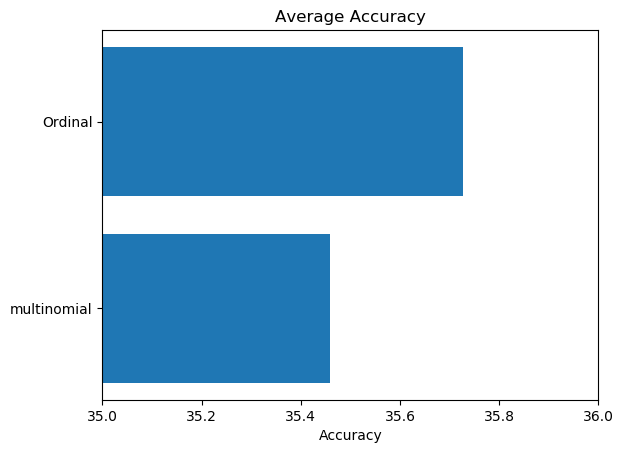

In [76]:
plt.rcdefaults()
fig, ax = plt.subplots()

model = ['Ordinal', 'multinomial']
accuracy_model = [35.728, 35.459]
ax.barh(range(2), accuracy_model, align='center', color='g')
ax.set_yticks(range(2))
ax.set_yticklabels(model)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Average Accuracy')
ax.set_xlim((35,36))

plt.show()

# 5.0 Model Tuning 

Now that's ordinal linear regression has been established has the best model, let's tune the following paramters:
- C 
- solver 

There are two different way to perform grid search. The first way is mandually build the model and determine the accuracy. The second way is by using the gridsearch function. The first method is less time consuming but this takes a long time, so code was outputted as a text. 

In [77]:
#kfold = KFold(n_splits=10)
#kfold.get_n_splits(features)

#best_model = model
#best_params = {}
#best_accuracy = 0
#best_std = 0
#data = []
#for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100,1000]:
    #for solver in ['newton-cg','lbfgs','saga','sag']:
        #accuracy=[]
        #for train_idx, test_idx in kfold.split(features):
            #X_train, X_test = features.values[train_idx], features.values[test_idx]
            #y_train, y_test = target.values[train_idx], target.values[test_idx]

         
            #X_train = scale.fit_transform(X_train)
            #X_test = scale.transform(X_test)
    

            #df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=C, solver=solver) 
    
            # isolate the predicted class to determine accuracy
            #pred = df['predicted_class']
            #ACC = accuracy_score(y_test, pred) *100
            #accuracy.append(ACC)
            
    
        #data.append(round(np.mean(accuracy),3))
        
        #if np.mean(accuracy) > best_accuracy:
            #best_model = model
            #best_params = {'C':C, 'solver':solver}
            #best_accuracy = np.mean(accuracy)
            #best_std = np.std(accuracy)
    
#print (best_params)
#print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      
#print(data)
#print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.01, 'solver': 'newton-cg'}
Best Score: 35.951%(3.154%)

data = [35.143, 35.143, 35.143, 35.143, 35.951, 35.951, 35.951, 35.951, 35.821, 35.821, 35.821, 35.83, 35.746, 35.737, 35.746, 35.746, 35.718, 35.728, 35.709, 35.728, 35.718, 35.718, 35.709, 35.709, 35.7, 35.7, 35.7, 35.7, 35.7, 35.691, 35.7, 35.7, 35.7, 35.7, 35.7, 35.7]

The optimal log model uses C=0.01, and a newton-cg solver, and has a cross validation score of 35.951% with a standard deviation of 3.154%

### Visualizing Accuracy for each model

GridSearch showed that C= 0.01, solver= newton-cg are the optimal parameters. Let's visualize the accuracy of the optimal model and compare to the other proposed models. 

In [78]:
# The accuracy of each solver for all C values
data = [35.143, 35.143, 35.143, 35.143, 35.951, 35.951, 35.951, 35.951, 35.821, 35.821, 35.821, 35.83, 35.746, 35.737, 35.746, 35.746, 35.718, 35.728, 35.709, 35.728, 35.718, 35.718, 35.709, 35.709, 35.7, 35.7, 35.7, 35.7, 35.7, 35.691, 35.7, 35.7, 35.7, 35.7, 35.7, 35.7]
df_solver= pd.DataFrame(np.array(data).reshape(9,4), columns= ['newton-cg','lbfgs','saga','sag'])
df_solver.index = df_solver.index.map(str)
df_solver.index= ['C=0.001', 'C=0.01','C=0.1','C=0.5','C=1','C=5','C=10','C=100', 'C=1000']
df_solver

,newton-cg,lbfgs,saga,sag
C=0.001,35.143,35.143,35.143,35.143
C=0.01,35.951,35.951,35.951,35.951
C=0.1,35.821,35.821,35.821,35.830
C=0.5,35.746,35.737,35.746,35.746
C=1,35.718,35.728,35.709,35.728
C=5,35.718,35.718,35.709,35.709
C=10,35.700,35.700,35.700,35.700
C=100,35.700,35.691,35.700,35.700
C=1000,35.700,35.700,35.700,35.700


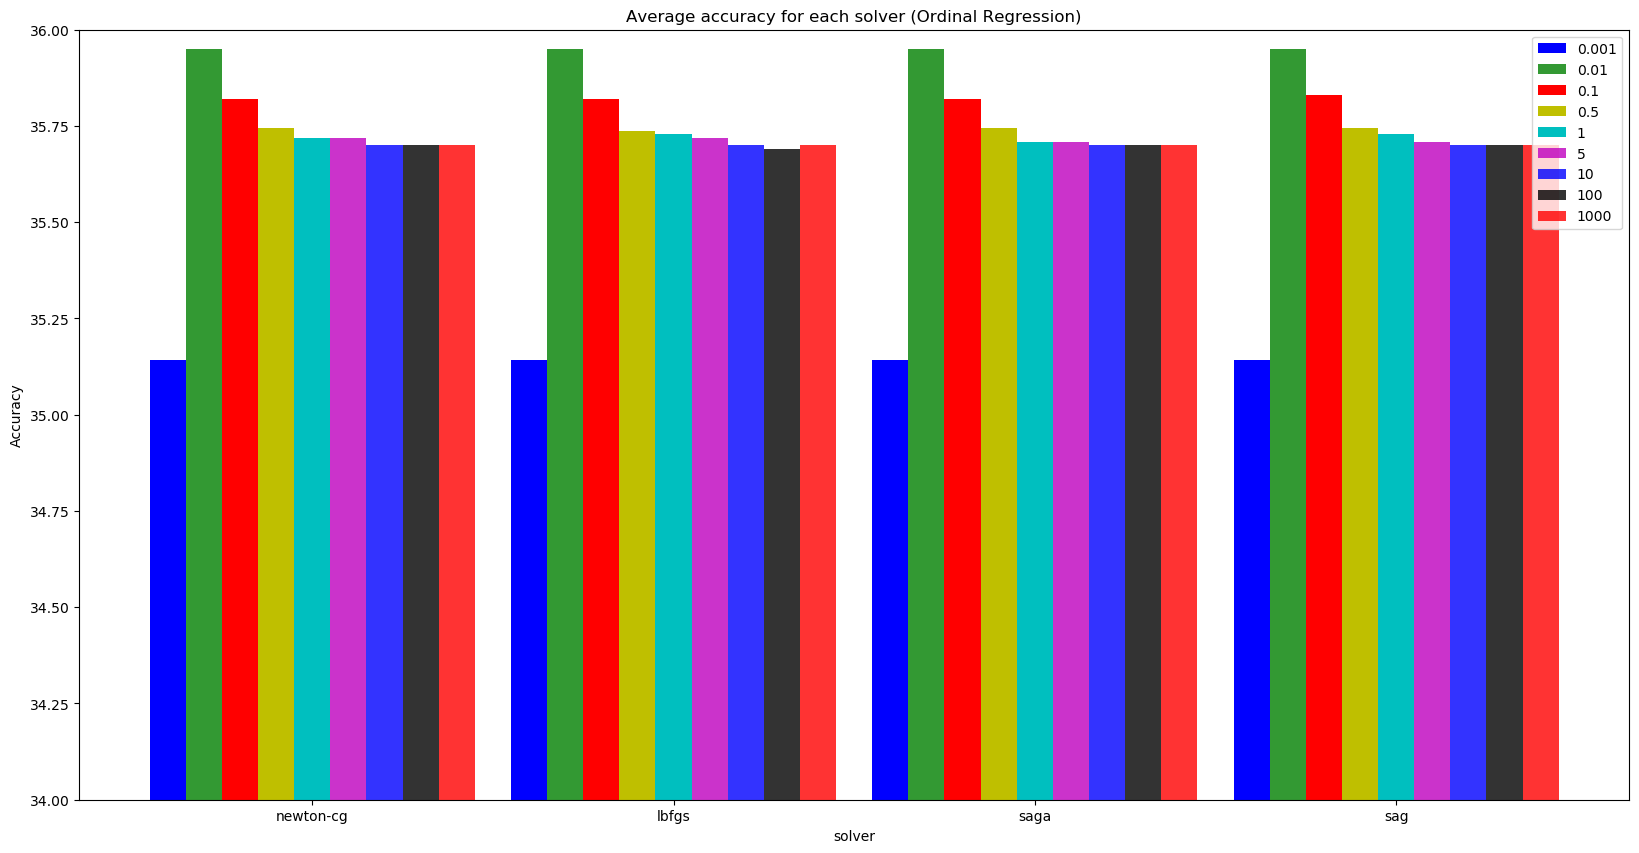

In [79]:
plt.figure(figsize=(20,10))
index = np.arange(4)
bar_width = 0.1
opacity = 0.8
C = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100,1000]

plt.bar(index, df_solver.iloc[0,:].values, bar_width, color='b', label='0.001')

plt.bar(index + bar_width, df_solver.iloc[1,:].values, bar_width,alpha=opacity,color='g',label='0.01')


plt.bar(index + bar_width*2, df_solver.iloc[2,:].values, bar_width,color='r',label='0.1')

plt.bar(index + bar_width*3, df_solver.iloc[3,:].values, bar_width,color='y',label='0.5')

plt.bar(index + bar_width*4, df_solver.iloc[4,:].values, bar_width, color='c',label='1')

plt.bar(index + bar_width*5, df_solver.iloc[5,:].values, bar_width,alpha=opacity,color='m',label='5')

plt.bar(index + bar_width*6, df_solver.iloc[6,:].values, bar_width,alpha=opacity,color='b',label='10')

plt.bar(index + bar_width*7, df_solver.iloc[7,:].values, bar_width,alpha=opacity,color='k',label='100')

plt.bar(index + bar_width*8, df_solver.iloc[8,:].values, bar_width,alpha=opacity,color='r',label='1000')



plt.xlabel('solver')
plt.ylabel('Accuracy')
plt.title('Average accuracy for each solver (Ordinal Regression)')
plt.xticks(index + bar_width*4, ('newton-cg', 'lbfgs', 'saga', 'sag'))
plt.legend(loc=1)
plt.ylim(34,36)

plt.show()

The graph above does confirm the results of the grid search. The solver newton-cg has the best accuracy at 35.951% for C=0.01. However we can also see that the remaining three solvers produced the same accuracy at C=0.01, indicating that any solver can be used for the optimal model as long as the regularization parameter is tuned to 0.01. This is not suprising because we saw in section 4.1 that average model accuracy did not change at all between the four solvers. 

In general, after tuning the accuracy went from 35.728% to 35.951% 

#### Visualize the confusion matrix for optimal model

In [80]:
target = pd.DataFrame(data=target) # binarizer expects a 2d array so I converted the target to dataframe, features was already a dataframe
features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=0.01, solver='newton-cg')  ###### change paramaters
    
# isolate the predicted class to determine accuracy
pred = df['predicted_class']  

(14.95, -0.01)

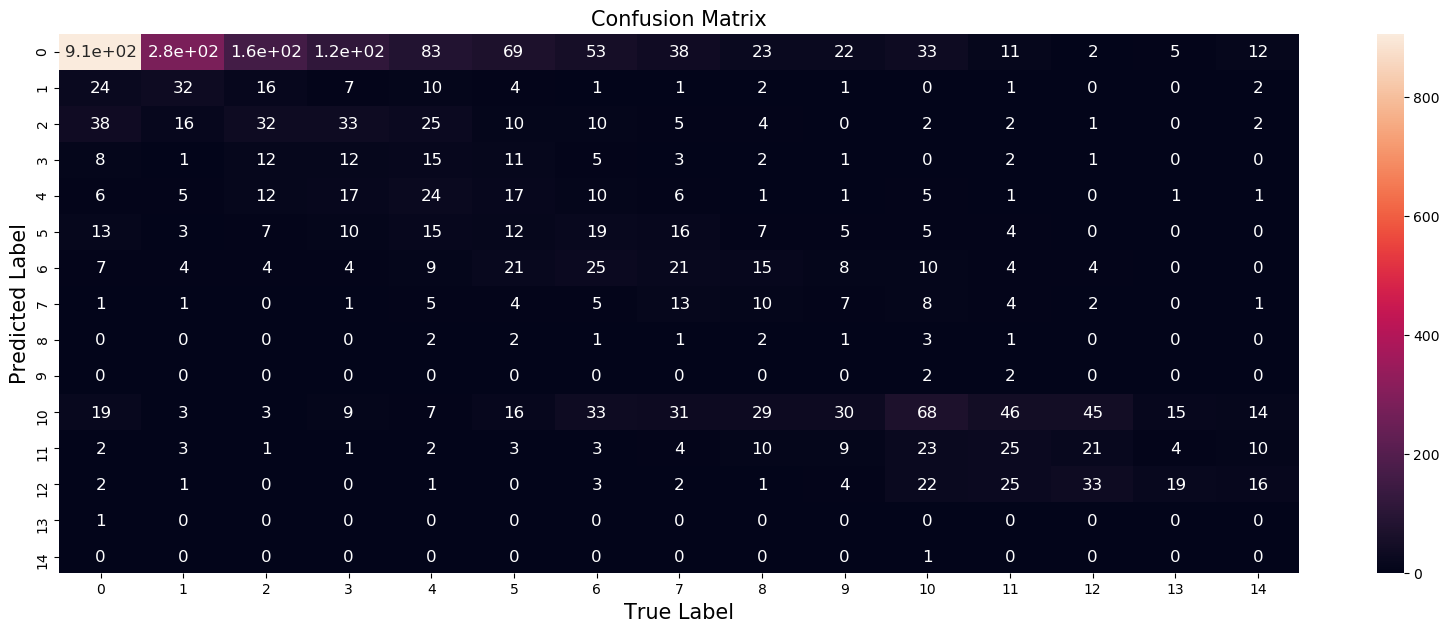

In [81]:
cm = confusion_matrix(pred,y_test)

df_cm = pd.DataFrame(cm, range(15), range(15))
plt.figure(figsize = (20,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)
plt.ylim(len(cm)-0.05, -0.01)

When we compare the confusion matrix of the the tuned model with that of the untuned model (section 4.1) there is some differences between the two. Some of the true positive values went up, for example class 1 went from 14 TP to 32 TP after tuning, however the False negatives (compared to class 2) also went up from 5 to 23. In general the matrix confirms that the accuracy of the tuned model isn't that much better than the tuned model. 

### Visualizing precision, recall, and F1 scores for various C parameters and optimal solver

In [82]:
# classification report
from sklearn.metrics import precision_recall_fscore_support
prec = []
re =[]
f= []
C = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100,1000]
for c in C:
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=c, solver='newton-cg') 
    pred = df['predicted_class']
    
    precision,recall,fscore,support=precision_recall_fscore_support(y_test,pred, average='macro')
    prec.append(precision)
    re.append(recall)
    f.append(fscore)

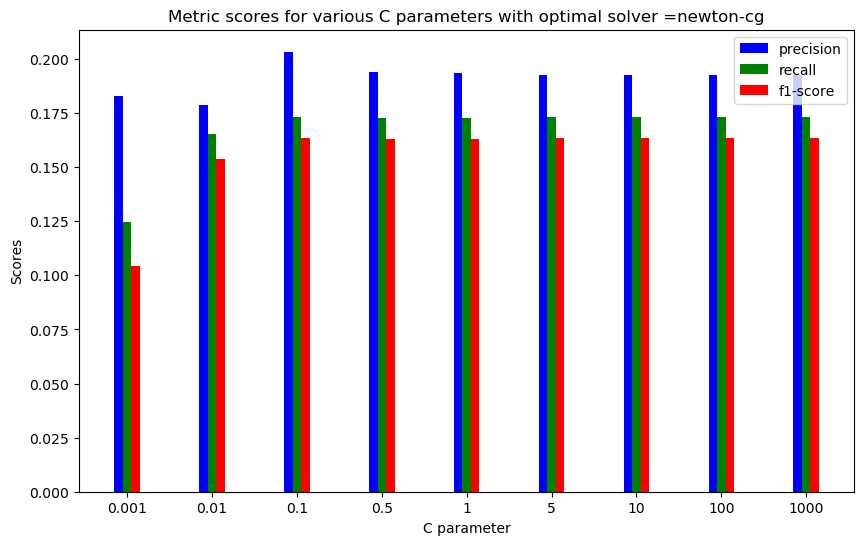

In [83]:
plt.figure(figsize=(10,6))
index = np.arange(9)
bar_width = 0.1
C = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100,1000]

plt.bar(index, prec, bar_width, color='b', label='precision')

plt.bar(index + bar_width, re, bar_width,color='g',label='recall')


plt.bar(index + bar_width*2, f, bar_width,color='r',label='f1-score')

plt.xlabel('C parameter')
plt.ylabel('Scores')
plt.title('Metric scores for various C parameters with optimal solver =newton-cg')
plt.xticks(index + bar_width, ('0.001', '0.01', '0.1', '0.5', '1', '5', '10', '100','1000'))
plt.legend()
#plt.ylim(0.46, 0.55)

plt.show()

The graph shows that the optimal model (C=0.01) had the best precision, but not the best recall or F1-score. This makes sense because recall and precision are tradeoff of one another. If you increase the recall of the model the more likely it will falsely classify the data and thus the precision will decrease. Sine they are tradeoffs, the way you can optimize precision and recall is by optimizing the F1-score, which is a combination of both. 

Our gridsearch did not optimize for F1 only accuracy; this is because it was computational expensive (grid search already takes 40+ mins without F1 optimization). This explains why the F1-score is not the best for the optimal model. This will probably not be the case if my gridsearch considered the F1-score. 

# 6.0 - Testing and Discussion

In [84]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=40)
    
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=0.01, solver='newton-cg') 
pred_test = df[['predicted_class']] 

accuracy_test = accuracy_score (y_test, pred_test)*100
print("The accuracy of the model on the test set is", round(accuracy_test,3),"%")


# determine the accuracy on training
X_test = X_train # I need to set X_test to X_train so that ordinal_fit_predict finds the probability of training data and not test data 
df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=0.01, solver='newton-cg') 
pred_train = df[['predicted_class']] 

accuracy_train = accuracy_score (y_train, pred_train)*100
print("The accuracy of the model on the train set is", round(accuracy_train,3),"%")

The accuracy of the model on the test set is 36.966 %
The accuracy of the model on the train set is 38.275 %


The accuracy of our model is not very good on either the training or the test data. The accuracy could be improved by dropping the empty entries rather than replacing them with logical decision such as 'Unknown'. However I did this to preserve data. Dropping the empty entries might delete useful information that the model can use. Also you can increase accuracy by potentially combining column 18 (languages known) into one column. I would do this by adding the number of languages that the respondent knows, into one column and then encoding said column. Having multiple columns for the same question might be confusing for the model and thus combining them might be helpful. Also in earlier trail of this assignment, I combined the salary buckets into 5 classes instead of 14, and the accuracy went up to 54+%, this is because the model has to predict less numbers are thus accuracy goes up.   

So let's know visualize how many classes were predicted for each salary buckets and compare them to the actual number. 

In [85]:
# reset index so that I can concate the dataframes
y_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
pred_test.reset_index(drop=True, inplace=True)
pred_train.reset_index(drop=True, inplace=True)

In [86]:
df_test_results = pd.concat([y_test,pred_test], axis=1)

In [87]:
df_train_results = pd.concat([y_train,pred_train], axis=1)

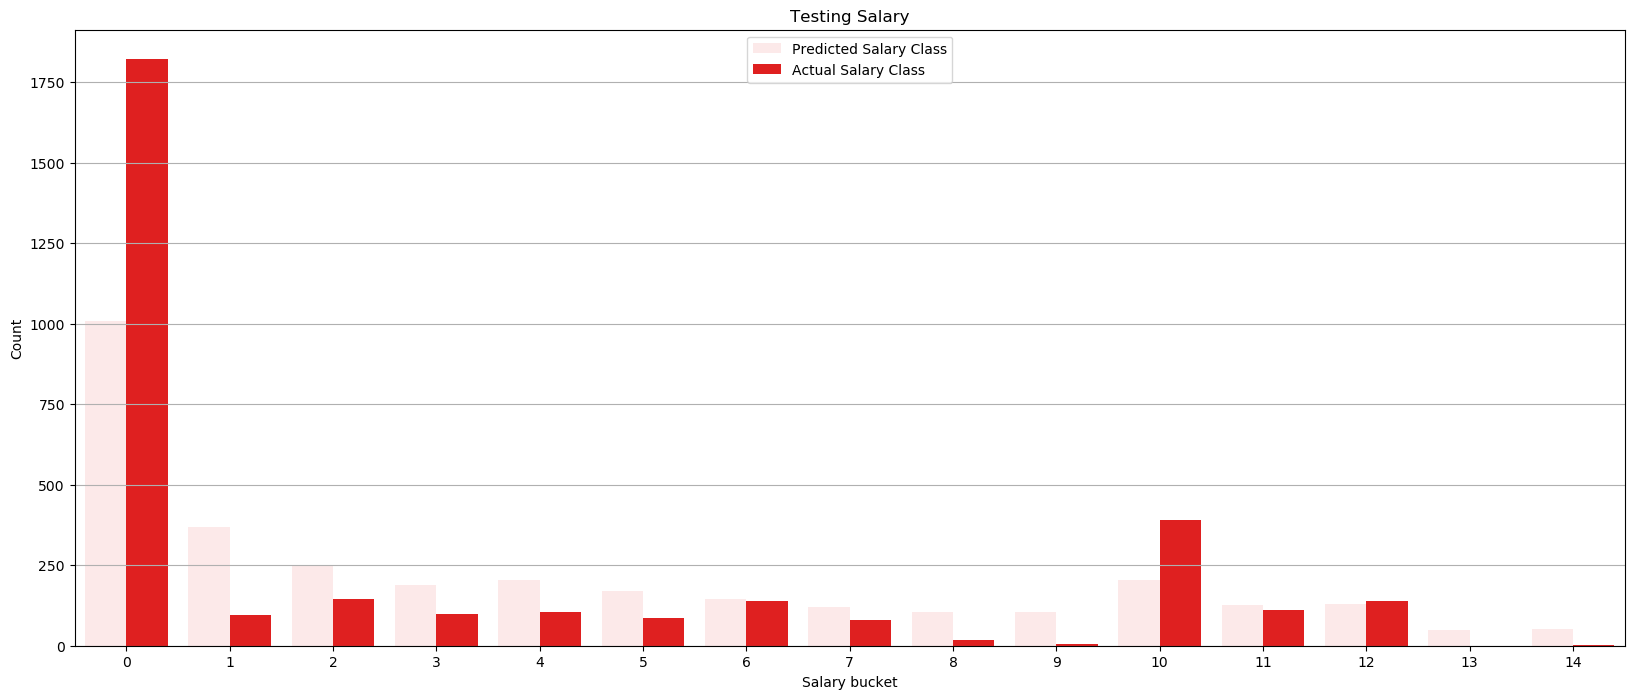

In [88]:
plt.figure(figsize=(20,8))
plt.grid()
sns.countplot(x="value", hue="variable", color = "red", data=pd.melt(df_test_results))
plt.xlabel("Salary bucket")
plt.ylabel("Count")
plt.title("Testing Salary")
plt.legend(["Predicted Salary Class","Actual Salary Class"])
plt.show()

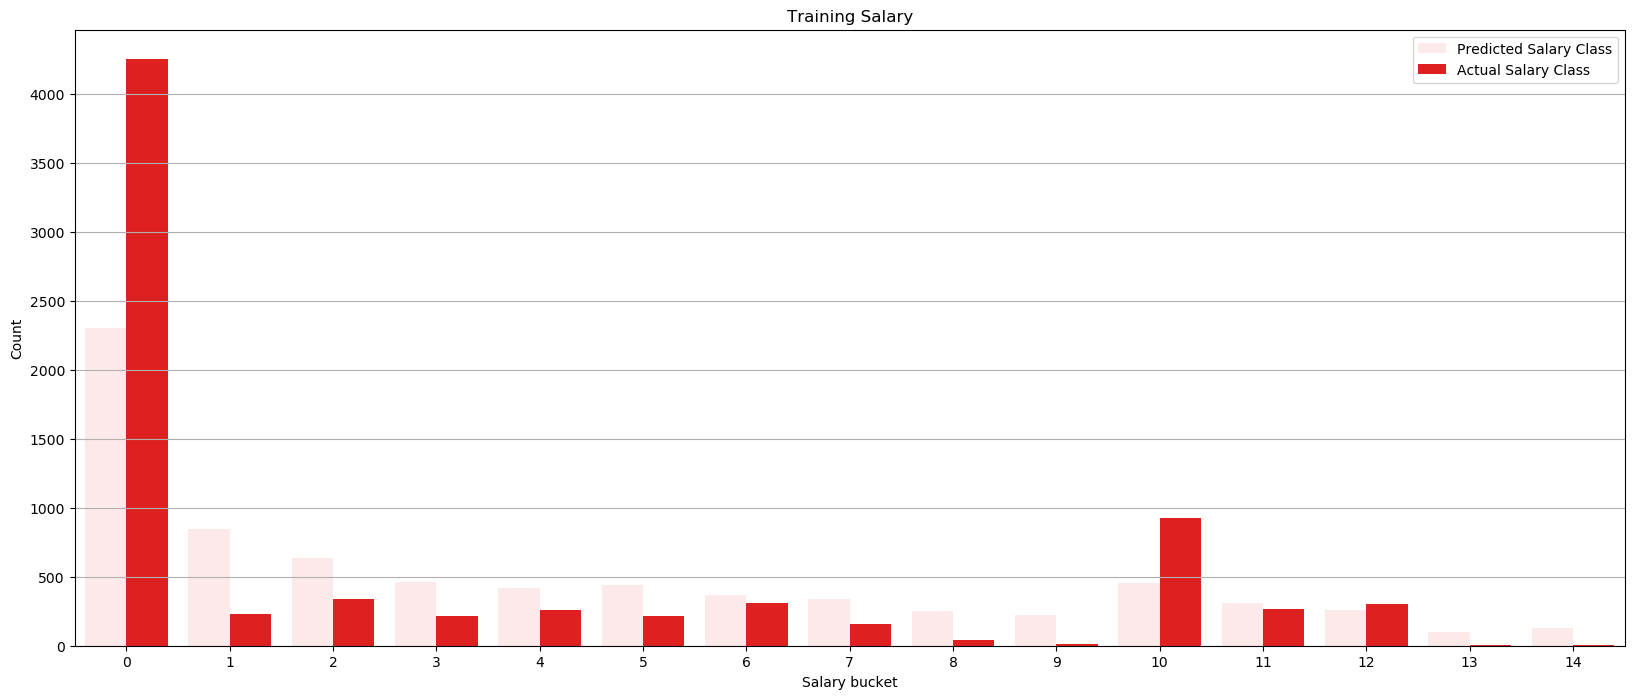

In [89]:
plt.figure(figsize=(20,8))
plt.grid()
sns.countplot(x="value", hue="variable", color = "red", data=pd.melt(df_train_results))
plt.xlabel("Salary bucket")
plt.ylabel("Count")
plt.title("Training Salary")
plt.legend(["Predicted Salary Class","Actual Salary Class"])
plt.show()

As you can see from the graph above class 0 and class 1 were two most predicted classes for both training and test data. For Class 0 it is not suprising as it has the most data, so the model will tend to lean towards predicting it. But class 1 doesn't have as much data so it's surprising that the model keeps predicting. In general, the graphs show that most salaries buckets have a higher predicted count than a actual count; this excludes class 0 and 10 where actual was higher than predicted. Furthermore these graphs also show that the model doesn't learn towards class 0 enough. 

### Visualizing Overfitting/underfitting Part 1

We can visualize how our model behaves when we increase the size of the training set by using the learning curve funciton. 

In [90]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score (Cross validation)")
    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/pyplot.py'>

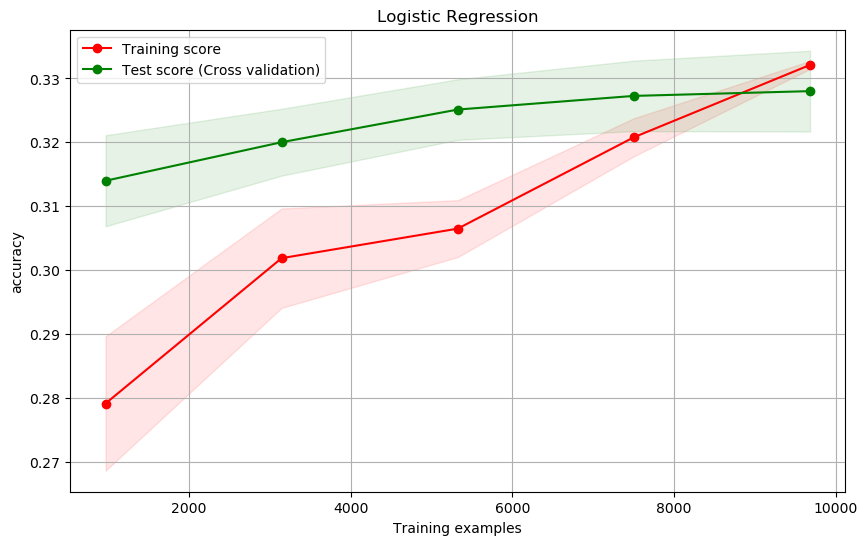

In [91]:
# this code takes a long time to exceute. I uploaded a picture of the graph, which can be run on jupyter notebook
#ordinalClass=LogisticRegression(C=0.01, solver='newton-cg')
#plot_learning_curve(ordinalClass,'Logistic Regression', features, target, cv=10)

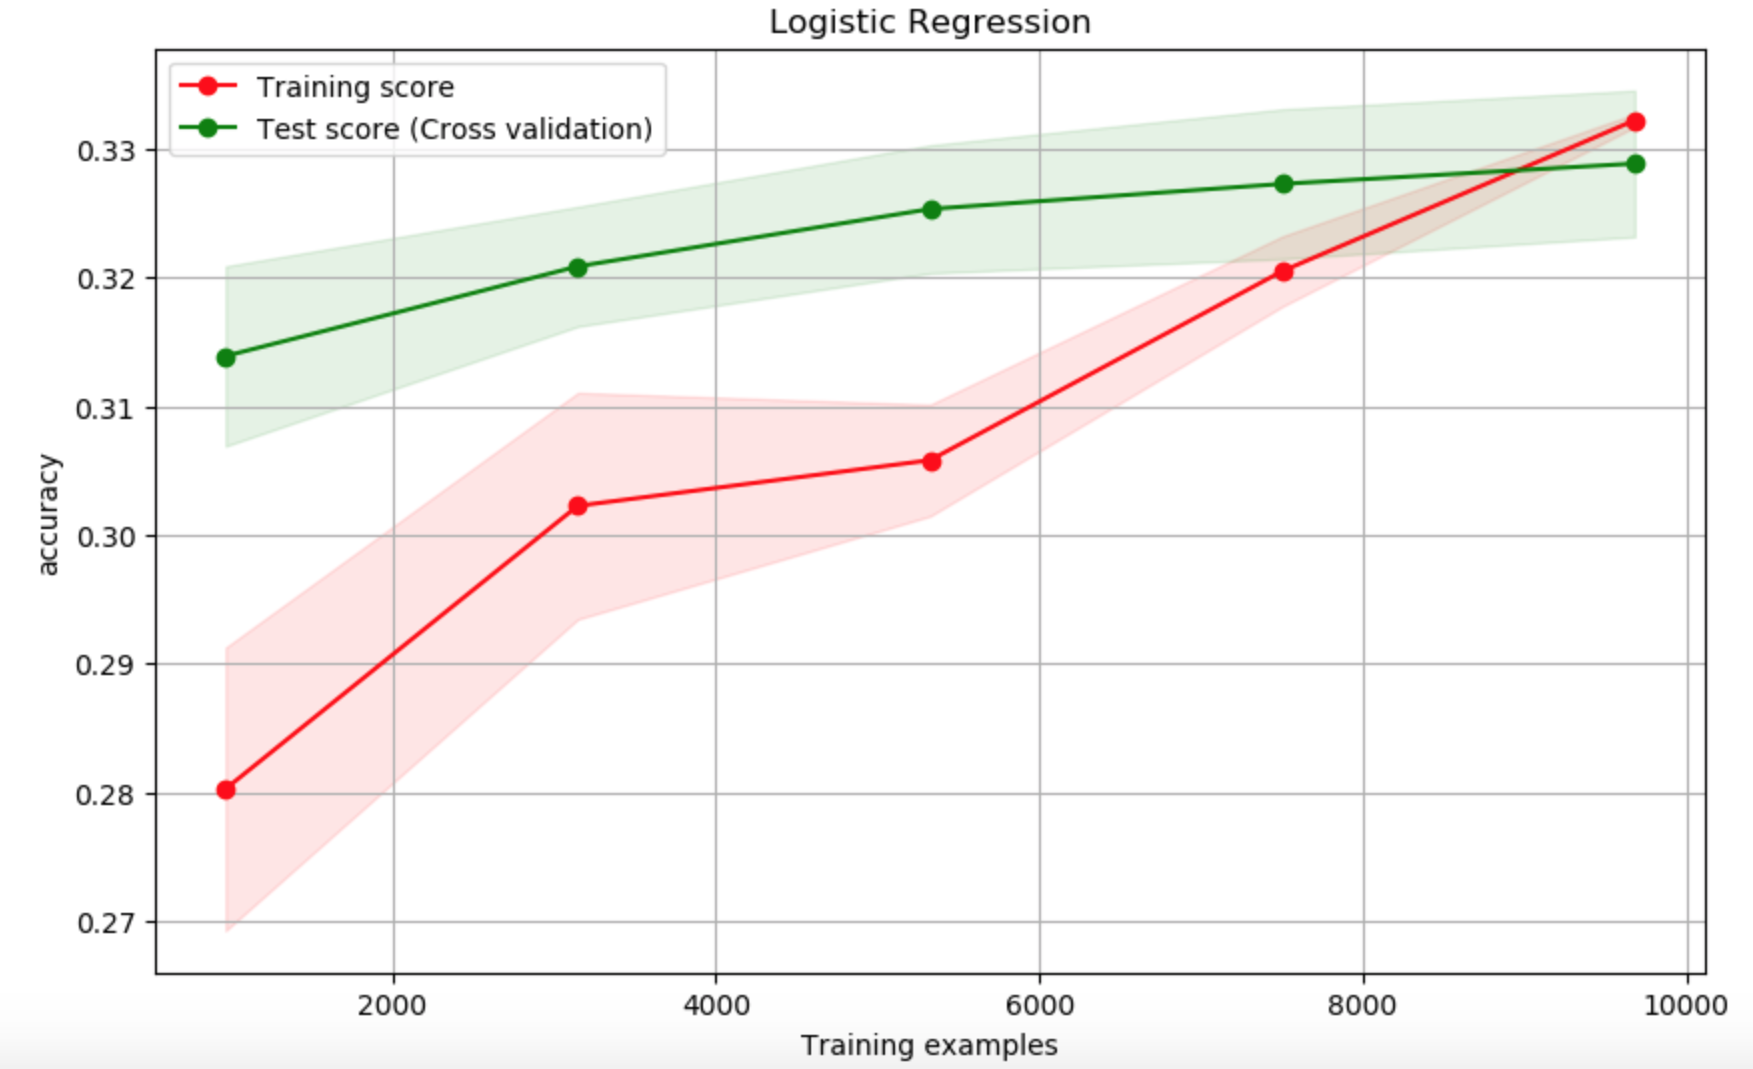

The graph above shows that the training accuracy is worse than the test error with a smaller training set. This indicates that the model will underfit if a smaller training set is used. Underfitting means we have high bias (high training error or low training accuracy) and low variance (low test error or high test accuracy).  

However as we increase the training examples the gap between the training and test data decreases; which means the variance is also decreasing. There also a point where the training accuracy intersects and becomes bigger than testing accuracy, this indicates slight overfitting where the variance is high (large training accuracy) and low bias (low training error because of higher accuracy). This indicates that adding training examples after or close to convergence point is a waste of time and will not improve our model (specifically it will not improve variance). 

Therefore, a good model means we want low bias and low variance, this happens when training example are approximately 7800. At that point the training accuracy is high, which means low training error and bias, and also the gap between training and test accuracy is relatively small, which means low variance. 

In general, to summarize:
- When the train accuracy is much higher than test accuracy, the model is overfitting the training data and it is not a good model to test on unseen data (high variance, low bias)
- When the test accuracy is much higher than the training accuracy, the model is underfitting the training data and is not a reliable mode (high bias, low variance)

### Visualizing Overfitting/underfitting Part 2

In [92]:
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=40)
    
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

testErr = []
C = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100,1000]
for c in C:
    df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=c, solver='newton-cg') 
    pred_test = df['predicted_class'] 

    testErr.append(mean_squared_error(y_test, pred_test))

In [93]:
# determine the error on training
C = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100,1000]
trainErr=[]
for c in C:
    X_test = X_train 
    df = ordinal_fit_predict(X_train,X_test, y_train, y_test, C=c, solver='newton-cg') 
    pred_train = df['predicted_class'] 
    trainErr.append(mean_squared_error(y_train, pred_train))

In [94]:
np.array(testErr) - np.array(trainErr) # gap between test and training error. 

array([0.61942247, 0.34149182, 0.43816288, 0.41419321, 0.43157566,
       0.44263489, 0.43679547, 0.42441054, 0.42640125])

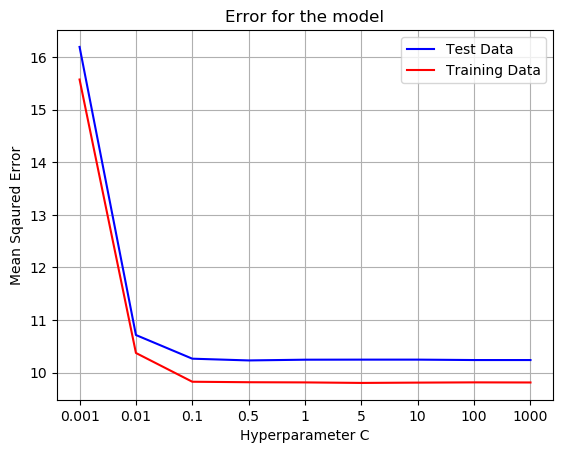

In [95]:
plt.plot(testErr, color ='b')
plt.plot(trainErr, color='r')
plt.ylabel("Mean Sqaured Error")
plt.xlabel("Hyperparameter C")
plt.xticks(range(9), ('0.001', '0.01', '0.1', '0.5', '1', '5', '10', '100','1000'))
plt.title("Error for the model")
plt.legend(['Test Data','Training Data'])
plt.grid()

The graph above shows the test and training error for various C parameters for solver newton-cg. As explained above, The smaller the gap is between training and test error, the lower the variance. The optimal model (C=0.01) has a smaller gap relative to all C values except for C=0.1, the gap there is a bit smaller. Nonetheless this indicates that my model has relatively low variance. 

Furthermore, although the the testing error is higher than training error, the gap isn't that large and thus I can say that model is not underfitting. It obviously also not overfitting because the training error is smaller. Therefore, since overfitting and underfittting don't apply, it can be concluded that the optimized model is a good machine learning algorithm for the features selected.

### Plotting Distribution of Final Optimal Model

Text(0.5, 1.0, 'Probabilty distribution for one individual (Actual Salary Class=10)')

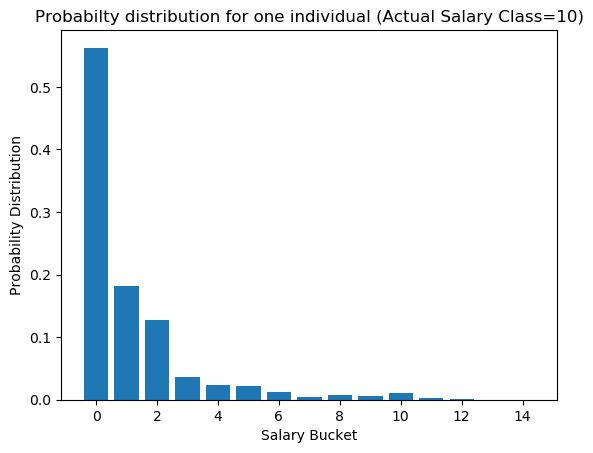

In [96]:
plt.bar( np.arange (15), df.iloc[0,0:15])
plt.xlabel('Salary Bucket')
plt.ylabel('Probability Distribution')
plt.title('Probabilty distribution for one individual (Actual Salary Class=%s)' % int(y_test[0:1].values))

The graph above illustrates that the model is doing a good job of predicted this individual's salary because it's skewed towards class 10 (the actual class). 